# *Task* - Visual Lane Following for Scaled Automated Vehicles


## Summary

This project has been conducted with the objective of developing an autonomous driving system for a small vehicle, with the implementation covering the steps between perception and actuation. The hardware used consists of a Waveshare Jetracer Nano [1] and an oval circuit, shown below:

![Waveshare Jetracer](https://www.waveshare.com/w/upload/thumb/9/98/JetRacer-AI-Kit-1.jpg/450px-JetRacer-AI-Kit-1.jpg)


## Index (needs editing)

+ Dependencies and Setup
    + Execution Environment
    + Downloads
    + Dependencies
+ Abstract
+ Introduction
+ Related Work
+ Methodology
+ Experiments
+ Evaluation
+ Required tools
+ Task
  + Image perception
  + Control and actuation
+ Conclusion

## Required tools

+ Python
  + OpenCV
  + matplotlib
  + numpy
  + Scikit-Learn

# Abstract

Autonomous transportation is rapidly moving from research toward real-world deployments, driven by advances in sensing, compute and control. Commercial systems achieving SAE Level 3 demonstrate the feasibility of conditional automation in constrained domains, and research efforts are increasingly focused on developing reliable subsystems that can be transferred from laboratory prototypes to field vehicles. Working with full-scale vehicles is costly and slow; therefore, scaled platforms provide an attractive intermediate step that reduces cost, shortens iteration cycles, and lowers safety risk while preserving the essential software and algorithmic challenges. This project adopts a 1:10 scaled platform (the ika Racer) to emulate a lane-following system: the goal is to replicate engineering trade-offs and validations that would be required for full-scale systems while enabling rapid prototyping, reproducible experiment design, and pedagogical use in teaching and demonstrations.

# Introduction

Working with full-scale vehicles is costly and operationally complex, so this research adopts a scaled-vehicle approach that preserves the essential perception, control and integration challenges while enabling rapid iteration and safe testing. The project implements a modular ROS pipeline that combines inverse-perspective mapping (IPM) and classical image preprocessing with several lane detection strategies ranging from simple heuristics to density-based clustering and learned line-segment detectors and evaluates their closed-loop performance on a scaled test course (Lot H). Using an experimental protocol that includes controlled lap trials, rosbag logging and quantitative metrics for reliability, tracking accuracy and passenger comfort, the study compares algorithmic robustness under real environmental variability (shadows, faded markings, potholes and curves).

The primary aim is twofold: (1) to produce a reproducible, low-latency lane-following pipeline suitable for resource-constrained onboard hardware, and (2) to empirically identify which detection strategies best balance reliability, comfort and speed in real tests. Deliverables include an image_processing ROS package, IPM calibration artifacts, rosbags and analysis notebooks to ensure reproducibility and practical transferability to larger platforms. Early results indicate that unsupervised clustering approaches that explicitly separate left and right lane lines (notably K-Means row search and DBSCAN clustering) achieve the best trade-off between robustness and real-time performance on the test track, while learned detectors (e.g., DeepLSD) can increase recall but require careful filtering and compute budgeting. These findings guide the methodology and the selection of fallbacks and confidence checks used in the final pipeline.

### Problem Statement

The central problem is to design, implement and validate a vision-based lane detection and lane-following pipeline for a 1:10 scaled vehicle that is (1) robust to realistic environmental variability, (2) efficient enough to run on resource-constrained hardware, and (3) reproducible and transferable so that lessons learned can inform full-scale vehicle development. Concretely, the project must detect and track lane markings, estimate centreline and curvature, and produce steering and speed commands that keep the vehicle safely within the lane boundaries. Success requires not only accurate perception but also reliable IPM calibration, timely control outputs with bounded latency, and an experimental setup that supports repeatable evaluation. The intended impact is twofold: produce a working demonstrator for research and teaching, and verify that the developed pipeline can be scaled or adapted to larger platforms.

### Objectives and Deliverables

#### Core objectives
• Develop a robust image-processing pipeline for lane detection and centreline extraction that is capable of estimating lane curvature and lateral offset.

• Generate steering and speed control outputs derived from the visual lane estimate, suitable for real-time closed-loop operation on the ika Racer.

• Ensure computational performance compatible with the onboard hardware target, with a processing throughput target of ≥10 FPS and end-to-end latency under 100 ms.

#### Deliverables
• An image_processing ROS package implementing the perception pipeline and communication topics.

• A tuned inverse perspective mapping (IPM) calibration package (scripts and calibration records).

• Experimental artifacts: rosbags with recorded runs, a Jupyter Notebook containing processed results and analyses, and presentation slides summarizing findings.

• Demonstration: closed-loop runs on the baseline test track meeting the stated success criteria (e.g., mean centreline error < 0.10 m under baseline conditions).

#### Success criteria & functional requirements
• Quantitative: centreline position error < 0.10 m on the baseline track; processing ≥10 FPS; latency < 100 ms.

• Interface: perception must publish lane_info (offset, curvature, confidence) and the system must produce acvp_msgs/DriveCommand messages to actuate steering and throttle.

#### Constraints and Risks

Constraints
• Project timeline is constrained to 12 weeks, imposing limits on the extent of experimentation and model training.

• Onboard compute is limited (Jetson Nano / similar), necessitating lightweight algorithms or selective offloading of heavy tasks.

• Testing is restricted to a predefined track and the scaled platform; this limits environmental diversity and may bias pipeline tuning to the specific track characteristics.

#### Major risks
• IPM miscalibration: small errors in perspective correction can produce substantial lateral or curvature estimation error downstream.

• Lighting variability and reflections: day-to-day illumination changes (glare, shadows) can significantly change the appearance of markings, degrading classical vision pipelines.

• Compute bottleneck: insufficient processing throughput or memory can force reduction of algorithmic complexity and degrade control performance.

• Integration mismatch: software components (perception, control, comms) may have incompatible rates or message semantics, causing timing faults in closed-loop trials.

#### Mitigations
• Systematic calibration procedures and verification checks; store calibration artifacts for reproducibility.

• Use data augmentation and robust thresholding, and implement simple adaptive illumination mitigation (e.g., histogram normalization).

• Profile and optimize critical code paths; offload expensive processing to native C++ where necessary and exploit light-weight detectors.

• Extensive offline testing with rosbags to validate interfaces before live trials, and staged integration testing to isolate mismatch sources.


# Related Work

### Largest White Contour
The Largest White Contour method is a classical, heuristic approach that relies on simple image preprocessing to isolate bright lane markings before selecting the most prominent contiguous region as a lane proxy. Typical preprocessing steps are color or intensity thresholding, morphological operations (e.g., erosion/dilation and blurring) to remove salt-and-pepper noise and merge fragmented markings, and contour extraction to identify connected components. This approach is attractive because it is computationally cheap, easy to implement on limited hardware, and provides quick baseline behavior in well-controlled, high-contrast scenes. However, its simplicity is also its primary limitation: the method is brittle under real-world variability such as faded markings, shadows, road debris, or other white objects (vehicles, signs) that create large bright regions. In practice this technique is most valuable as a rapid prototyping baseline or as a component inside a larger pipeline (for instance, as an initial hypothesis that a more robust module then verifies), rather than as a standalone production solution.

![Largest-Contour-and-Offset-Point_W640.jpg](images/Largest-Contour-and-Offset-Point_W640.jpg)


### Least-Squares Regression Line Fit (LSRL)
Least-squares regression for lane fitting follows an edge- or segment-extraction stage (e.g., Canny + Hough) and fits parametric models to the detected points—commonly straight lines (y = mx + b) or low-order polynomials after transforming the image to a bird’s-eye (IPM) view. The main advantage is the explicit, compact parametric representation of lane boundaries, which simplifies downstream computations such as centreline, lateral offset and curvature estimation. Bird’s-eye projection often improves stability by reducing perspective-induced point density gradients. The drawbacks include sensitivity to outliers and non-lane edges: a few spurious points can bias the regression, and a purely linear fit will poorly represent strong curvature. Robust variants (RANSAC, weighted least squares, or polynomial fitting) and careful preprocessing are commonly used to mitigate these issues; nonetheless, LSRL remains best suited to environments where lane markings are continuous and approximately straight over the fitting window.

![DBSCAN-Clustering-Lane-Lines_W640.jpg](images/DBSCAN-Clustering-Lane-Lines_W640.jpg)

### Linear Row Search with K-Means
The linear row search method reduces the detection problem to one (or a few) selected horizontal image rows: bright pixel x-coordinates along the row are extracted and clustered (typically K=2) to obtain left and right lane centroids. Because only a small slice of the image is processed, this approach achieves very low latency and is straightforward to time-synchronize with control loops, making it appealing for real-time embedded platforms. Temporal smoothing of centroids (simple exponential averaging or storing a short history) increases robustness to intermittent detection loss. Its main limitations arise from the row selection: if the chosen row intersects gaps, occlusions, or reflections, the clustering may produce incorrect centroids or fail outright; the method also degrades on strong curves where a single horizontal row poorly represents lane geometry. Therefore, linear row search is often used in combination with validation checks (confidence thresholds, multi-row consensus) or as a fast fallback in multi-algorithm ensembles.

![Visualization-of-Linear-Lane-Search-with-K-Means_W640.jpg](images/sualization-of-Linear-Lane-Search-with-K-Means_W640.jpg)

### DBSCAN Clustering of Edge Points / Segments
DBSCAN-based methods cluster dense groups of lane-related points or short Hough segments using a density metric rather than specifying a fixed number of clusters. This density-driven approach naturally separates left and right lane candidates even when segments are discontinuous or nonuniformly distributed, and it can be more robust on moderate curves because it groups local structure rather than enforcing a global parametric split. DBSCAN’s major practical consideration is parameter sensitivity: the neighborhood radius (epsilon) and minimum points threshold must be chosen relative to image scale and typical segment spacing, and they often require retuning across camera setups or track geometries. Additionally, perspective effects can make left/right densities uneven (nearer lane parts producing denser clusters), so DBSCAN typically benefits from IPM or depth normalization. When tuned correctly, it is a powerful middle ground between simplistic heuristics and heavy learned detectors, especially for cluttered or partially degraded markings.

![DBSCAN-Clustering-Lane-Lines_W640.jpg](images/DBSCAN-Clustering-Lane-Lines_W640.jpg)

### DeepLSD (Learned Line-Segment Detection + Postprocessing)
DeepLSD and similar learned line-segment detectors apply convolutional neural networks to detect many short, local line segments directly from images; subsequent filtering and classical postprocessing (masking, length/angle thresholds, clustering and model fitting) produce lane hypotheses. The learned front-end often finds subtle or low-contrast segments that thresholding-based pipelines miss, increasing recall in challenging lighting or texture conditions. However, learned detectors also respond to non-lane linear structures (cracks, joints, shadows), producing high false-positive rates unless paired with careful geometric or semantic filtering. Moreover, they impose higher computational cost and latency, which can be problematic on constrained edge hardware unless the model is pruned or quantized. In practical workflows, DeepLSD is most useful when combined with classical constraints (IPM, geometric priors) and fast clustering (e.g., DBSCAN) so that only high-confidence segments influence control decisions—trading some latency for improved detection robustness.

![deeplsd.png](images/deeplsd.png)

# Methodology

Below is a descriptive Methodology section you can copy into your report. It follows a logical order (testbed → hardware → software → perception → control → experiments) and expands the concise slide material into full paragraphs suitable for a written report. Citations point to the PPT slides you provided.

3.1 Experimental testbed and simulation environment

The project used a two-stage experimental approach: development and early validation in simulation, followed by transfer and closed-loop experiments on a 1:10 scaled physical vehicle (the ika Racer) running on the Lot H test track. Simulation environments provided a safe, rapid iteration loop for algorithm prototyping and parameter sweeps; they reproduce core dynamics and sensing modalities (camera, IMU) while allowing controlled variation of road geometry and nominal lighting. The successful candidates from simulation were ported to the real vehicle and validated in incremental steps: offline replay with rosbag data, open-loop perception verification, and finally staged closed-loop trials. This process reduced the risk of hardware faults and allowed reproducible comparison between algorithms across identical recorded runs.

3.2 Vehicle platform and sensors

The scaled vehicle follows a typical perception–planning–actuation layout. Sensors used include a forward-facing monocular RGB camera as the primary lane perception sensor, supported by vehicle odometry and an IMU for motion state estimation. The vehicle is equipped with a drive-by-wire interface that accepts steering and throttle commands (published as acvp_msgs/DriveCommand), enabling direct control from ROS nodes. On-board compute is constrained (edge-class device), which shaped algorithmic choices toward lightweight and low-latency solutions. These hardware constraints motivated careful profiling and a preference for classical vision algorithms or trimmed learned modules that meet real-time throughput targets.

3.3 Software architecture and ROS integration

The system is organized as a set of modular ROS nodes to ensure clean separation of concerns and repeatability of experiments. Key nodes include: a Camera/Driver node (publishes raw image topics), an IPM/Calibration node (performs perspective transforms), an Image Preprocessor (color/thresholding, morphological cleanup), a Lane Detector (implements multiple detection algorithms and publishes lane point clouds), a Lane Estimator (fits parametric models and computes centreline/curvature), a Controller node (computes steering/throttle commands), and a Vehicle Node (handles actuation and safety interlocks). Nodes expose dynamic reconfigure parameters so algorithms and thresholds can be tuned online during experiments, and the architecture supports multiple detection algorithms running in parallel or being swapped at launch-time for side-by-side evaluation. Detailed topic naming, message types, and launch scripts were maintained to support reproducibility and automated replay of trials.

3.4 Camera calibration and inverse perspective mapping (IPM)

A robust IPM (bird’s-eye) transform is applied as a preprocessing step to reduce perspective distortion and to make lane geometry more nearly parallel and scale-consistent. Calibration consists of intrinsic calibration for lens distortion (focal length, principal point, distortion coefficients) and extrinsic calibration relative to the vehicle frame (pitch and mounting height). The IPM mapping matrix is computed from these parameters and validated by projecting known planar points and verifying residual errors. Because small IPM errors amplify downstream (lateral offset and curvature estimation), calibration artifacts (scripts, calibration images, parameter files) are versioned and recorded with each experiment for traceability. When small calibration shifts occur between runs, published calibration checks are used to detect and correct them before live trials.

3.5 Image preprocessing pipeline

The preprocessing stage prepares raw camera frames for robust extraction of lane-related structure. Standard steps include color space conversion (RGB → HSV) and adaptive thresholding to isolate typical lane hues, median or Gaussian blur for small-noise reduction, and morphological operations (dilation/erosion) to close small gaps in markings and remove speckle. A region-of-interest (ROI) mask reduces processing to the road area ahead of the vehicle, improving runtime and reducing distractors. Edge emphasis using a Sobel X filter or combined gradient weighting is applied to increase contrast of lane lines, and output from these stages is fused into a binary lane probability image. These well-documented, deterministic preprocessing operations make the detection algorithms more robust to modest lighting variation and reduce false positives from roadside clutter.

3.6 Lane detection methods (algorithms implemented and tested)

Multiple detection strategies were implemented so their trade-offs could be compared under identical test conditions. Each method consumes the preprocessed binary/edge image and outputs lane point candidates or short line segments; examples follow:

Largest White Contour (heuristic): After thresholding and morphological cleanup, connected components are found and the largest bright contour is selected as a lane proxy. This approach is computationally cheap and serves as a quick baseline; however, it is brittle to extraneous bright objects and fragmented markings.

Least-Squares Regression Line Fit (LSRL): Edge points or short Hough segments are grouped for left/right lanes (optionally after IPM) and a least-squares fit (or polynomial fit in the BEV domain) yields a parametric lane model. Robustification strategies such as RANSAC or weighted fitting reduce outlier influence. This yields interpretable centerline and curvature estimates but requires careful preprocessing.

Linear Row Search with K-Means: One or more horizontal rows are sampled for bright pixel x-positions; a K=2 clustering produces left/right centroids. Temporal smoothing of centroid positions helps handle intermittent failures. This method is extremely low-latency, appropriate as a fallback, but sensitive to occlusion or missing row data.

DBSCAN clustering of edge points/segments: Density-based clustering groups local points or Hough segments without fixing the number of clusters; clusters corresponding to left/right lanes are fitted and selected by geometric priors. DBSCAN handles discontinuities and variable segment density but requires tuning of eps and minPts, often relative to the BEV scale.

DeepLSD (learned line-segment detection) + postprocessing: A pretrained deep detector is used to extract many short line segments; these are filtered by length/angle and clustered (e.g., DBSCAN) before parametric fitting. The learned detector increases recall on subtle segments but requires heavy geometric filtering to remove false positives such as cracks and road joints. Inference time and latency trade-offs are taken into account — DeepLSD provided useful detections but added measurable latency (on the test laptop ~0.15 s/frame), and thus required balancing against real-time control constraints.

For each algorithm, explicit failure modes were documented (e.g., K-Means failing when the sampled row intersects a gap; DBSCAN merging clusters on tight curves unless IPM is applied). Default parameter choices and the rationale for tuning (temporal smoothing windows, morphological kernel sizes, clustering radii expressed in BEV pixels) were recorded to ensure experiments are reproducible.

3.7 Lane fitting, centreline and curvature estimation

Once per-lane point sets or segment clusters are obtained, the Lane Estimator fits parametric models: straight lines for short look-ahead windows or low-order polynomials for curved sections. Lane centreline is computed as the midpoint between left and right fits, and lateral offset is obtained by projecting the vehicle reference point into the BEV frame and computing its signed distance to the centreline. Curvature is derived from the fitted polynomial: for a parametric polynomial y(x), curvature κ(x) = |y''(x)| / (1 + y'(x)^2)^{3/2} and turning radius R(x) = 1 / κ(x). Look-ahead points for geometric controllers (e.g., Pure Pursuit) are computed on the centreline at a fixed distance ahead or using a speed-dependent look-ahead law. Confidence metrics (point density, fit residuals, temporal consistency) accompany each estimate to permit higher-level logic to select robust actuation strategies or fallback behaviors.

3.8 Control strategies and perception-to-actuation mapping

Perception outputs are consumed by a controller node to produce acvp_msgs/DriveCommand messages which actuate steering and throttle. The primary controllers implemented are a PID baseline for direct lateral offset control and a Pure Pursuit geometric controller that uses look-ahead points on the centreline to compute a steering angle. For benchmarking, offline Model Predictive Control (MPC) trajectories were computed to quantify achievable performance under perfect perception. Controller design accounted for actuator limits, sampling rates and measured latency: the effective control loop rate and perceptual confidence determine whether a direct steering command is sent or whether safe deceleration/fallback is triggered. Implementation includes anti-windup in PID loops, temporal smoothing of commands, and bounds checking to ensure stable closed-loop behavior on the physical vehicle.

3.9 Experimental protocol, metrics and logging

A standardized experimental protocol was adopted to ensure comparability between algorithms. Each experimental condition consists of multiple timed laps (inner/outer paths) at fixed nominal speeds, repeated to collect sufficient samples for statistical analysis. Primary evaluation metrics include: reliability (completion rate, number of attempts to complete a lap), path-tracking accuracy (mean and RMS lateral centreline error), comfort (steering smoothness and jerk metrics), and speed/lap time. Data collection is performed via rosbag recordings that capture raw imagery, estimator outputs, controller commands, and ground-truth odometry. Post-processing scripts compute metrics such as lateral error and curvature over time (Haversine formula or BEV metrics for path length), and produce visualization plots for qualitative inspection. These procedures make experimental comparisons reproducible and allow identification of failure cases to guide algorithmic improvements.

3.10 Implementation details, profiling and reproducibility

Because of onboard compute constraints, the implementation emphasizes low-overhead processing and careful profiling. Time-critical paths (image decoding, morphological ops, clustering) were profiled and, where necessary, moved to optimized native code or parallelized. The system exposes configuration via dynamic_reconfigure and structured parameter files; calibration artifacts, rosbag datasets, and processing notebooks are archived in the project repository so runs can be replayed and results reproduced. Latency measurements (camera publish rate vs model inference time) were recorded for each method and used to make real-time feasibility decisions (e.g., using K-Means as a fallback when learned detectors exceed latency budgets). All tested algorithms and parameter sets are documented to allow future researchers to replicate the experiments.

### Canny Edge/Hough Transform approach

The first approach taken for lane detection involved the canny edge [2] approach. By detecting so-called "edges" (high values in the image's grey scale gradient, obtained by using the Sobel operator), it is possible to recognize features with a simple and fast algorithm. This method's main principle is described by the following equation:

<img src="attachment:4f277c8e-8584-4079-83d1-e13d3b94b30e.png" style="margin-left:auto; margin-right:auto"/>

Afterward, the image is scanned and unwanted pixels are removed so that only local maxima remain, thus creating "thin edges".

Hysterisis thresholding is also performed, where edges with a gradient below a certain minimum value are suppressed, while the ones above a maximum boundary are kept (so called sure-edges). Edges which lie between minimum and maximum values are kept, if connected to sure-edges.

The OpenCV library provides a function [3] covering all these steps, with the referred minimum and maximum values used as arguments, as well as an aperture size (number of pixels used in the calculation of a gradient). Below is an example for this application, with four examples for the function's output: one with already tuned parameters (despite the high amount of noise, this was the best solution found). A higher maximum gradient value was tested in order to remove noise, but it only resulted in the suppression of the desired edges, since these have smaller gradients than the surrounding features. A lower minimum gradient value results in more noise, as expected, while a higher aperture size also drastically increases the sensitivity of the function.

In [80]:
!pwd    # prints current working directory
!ls     # lists files/folders here


/home/om/Projects/report/acdc-research-project-ss25/topics/07-Visual-Lane-Following-for-Scaled-Automated-Vehicles
assets				lane_detection_v1
bags				lane_detection_v2
centerline_detection		outputs
data				papers
docs				README.md
images				report.ipynb
jupyter-notebooks		scaled-acv-device-platform
lane_detection_hough_transform	task.ipynb


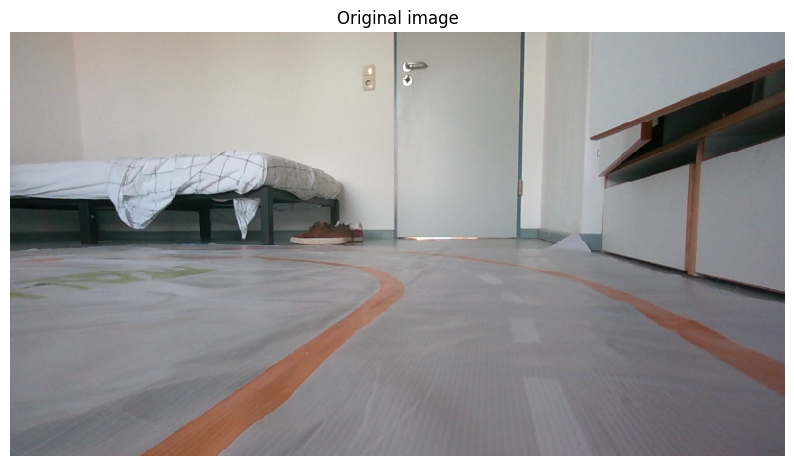

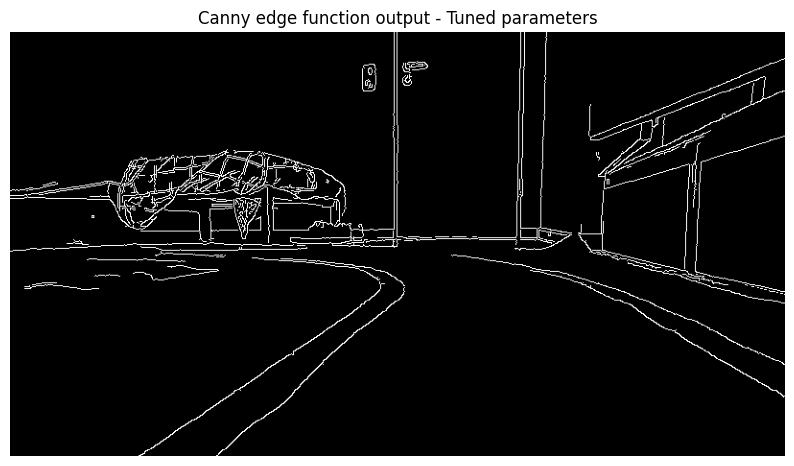

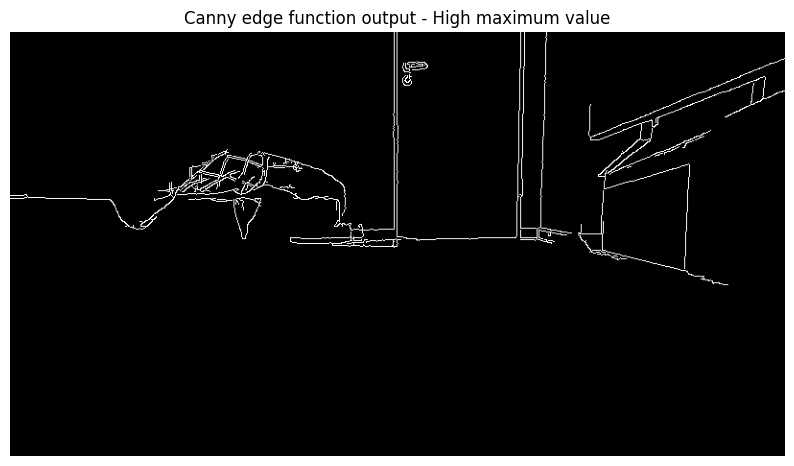

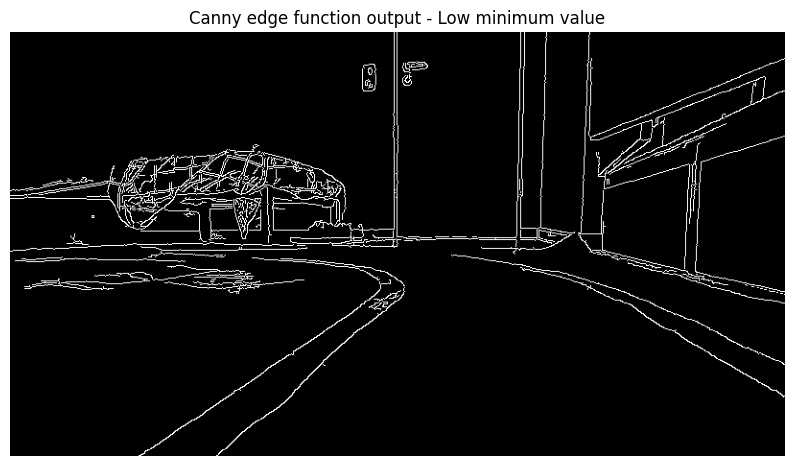

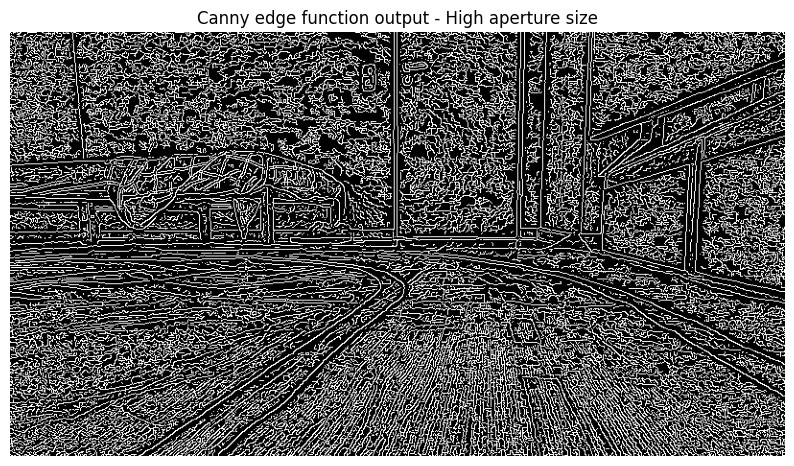

In [81]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

def display_image(image, title="Image", cmap=None):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

src               = cv2.imread(cv2.samples.findFile('images/image_raw_example.jpg'))
canny_base        = cv2.Canny(src, 50, 200, None, 3)
canny_high_maxval = cv2.Canny(src, 50, 500, None, 3)
canny_low_minval  = cv2.Canny(src, 10, 200, None, 3)
canny_high_ap     = cv2.Canny(src, 50, 200, None, 5)

display_image(src, 'Original image')
display_image(canny_base, 'Canny edge function output - Tuned parameters')
display_image(canny_high_maxval, 'Canny edge function output - High maximum value')
display_image(canny_low_minval, 'Canny edge function output - Low minimum value')
display_image(canny_high_ap, 'Canny edge function output - High aperture size')

After tuning the canny edge function, there was still considerable noise in the function output. A possible solution would be using a Hough line transform, a computer vision algorithm which would search for edge pixels forming straight lines, thus filtering out features with irregular profiles.

The OpenCV library provides a function covering this approach, which takes as arguments:

1. A grey-scale image (in this case the output from the canny edge function)
2. Two resolution values, one for the distance to the origin of the referential (rho) and another for the inclination (theta) of the lines to be searched
3. A detection threshold (number of detected segments to consider a line straight)
4. Two divisors for multi-scale Hough transform (src and stn)
5. Minimum and maximum values for theta (not used in this case)

The function's application is shown below. (It is worth noting that)

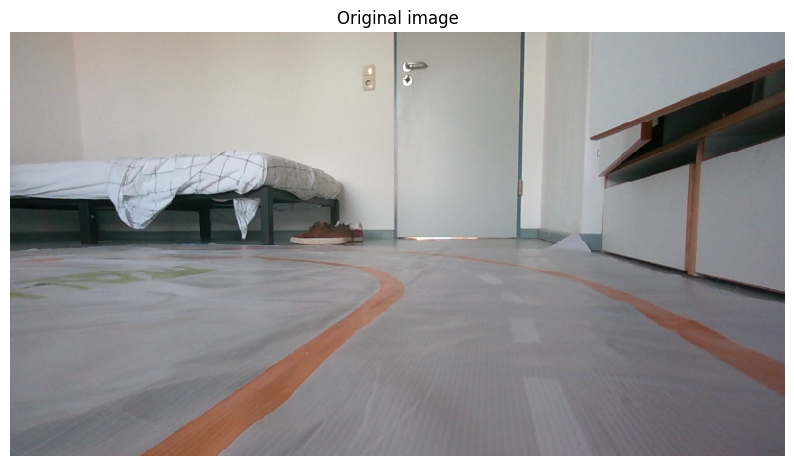

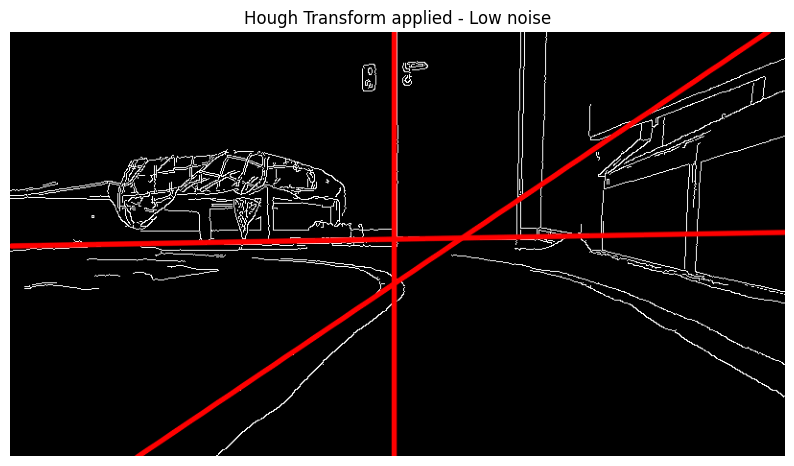

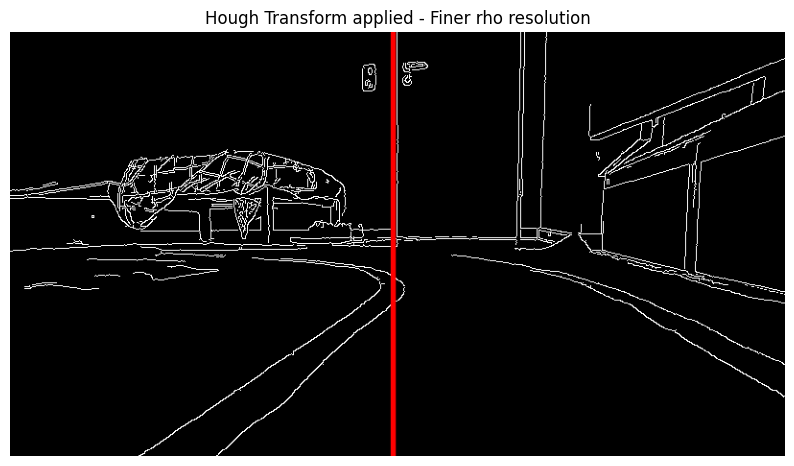

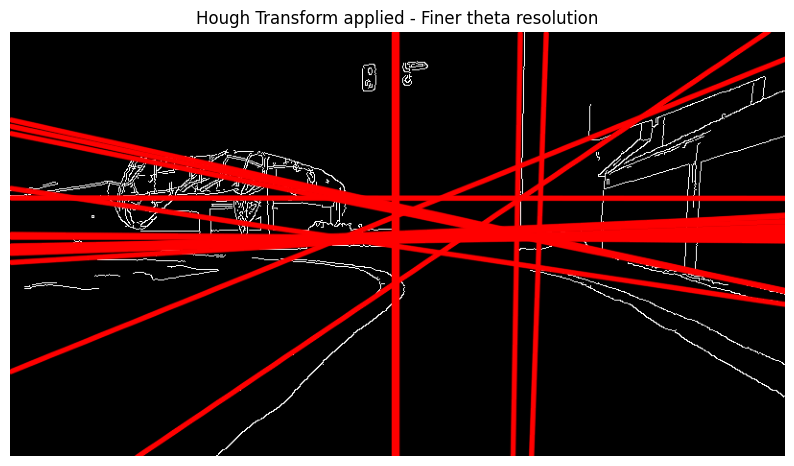

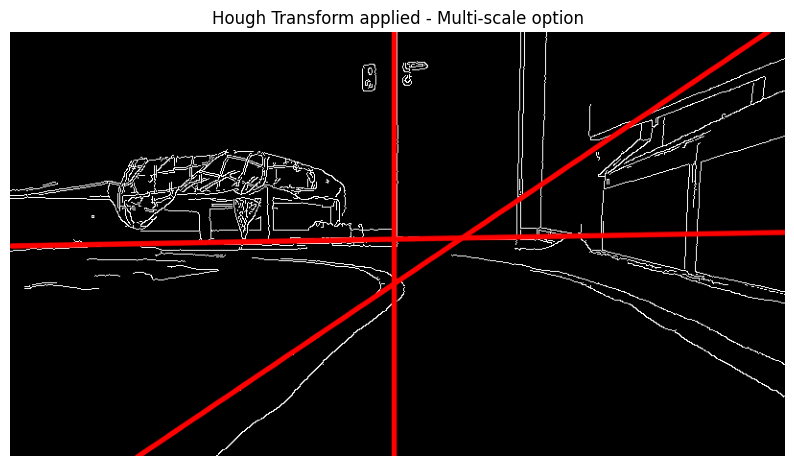

In [82]:
def HoughTransform(img, rho, theta, threshold, src=None, stn=None):

    # Apply Hough transform
    lines = cv2.HoughLines(img, rho, theta, threshold, None, src, stn)
    hough = cv2.cvtColor(canny_base, cv2.COLOR_GRAY2BGR)

    # Graphical representation of detected lines in the input image
    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            cv2.line(hough, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)

    return hough

hough_base = HoughTransform(canny_base, 1, np.pi/180, 200)
hough_1  = HoughTransform(canny_base, 0.5, np.pi/180, 200)
hough_2 = HoughTransform(canny_base, 1, np.pi/360, 150)
hough_3 = HoughTransform(canny_base, 1, np.pi/180, 200, 1, 1)

display_image(src, 'Original image')
display_image(hough_base, 'Hough Transform applied - Low noise')
display_image(hough_1, 'Hough Transform applied - Finer rho resolution')
display_image(hough_2, 'Hough Transform applied - Finer theta resolution')
display_image(hough_3, 'Hough Transform applied - Multi-scale option')

After some trial and error with the function's arguments, it was concluded the function wasn't viable for filtering out noise, given the way how some of the undesired features persisted, whereas the lane features were consistently removed.

Another option was tested, the probabilistic Hough transform, also with a function provided by OpenCV. The main difference to the previous function is the fact that it searches for adjacent pixels and outputs line segments instead of lines, thus being more appropriate for the given application.
As arguments, it would use:

1. An input grey-scale image
2. rho and theta values for resolution (similar to HoughLines())
3. A detection threshold, also similar to HoughLines()
4. A minimum value for segment length
5. A maximum value for the distance between detected segments to consider them a common detection

Below is the application of the function:

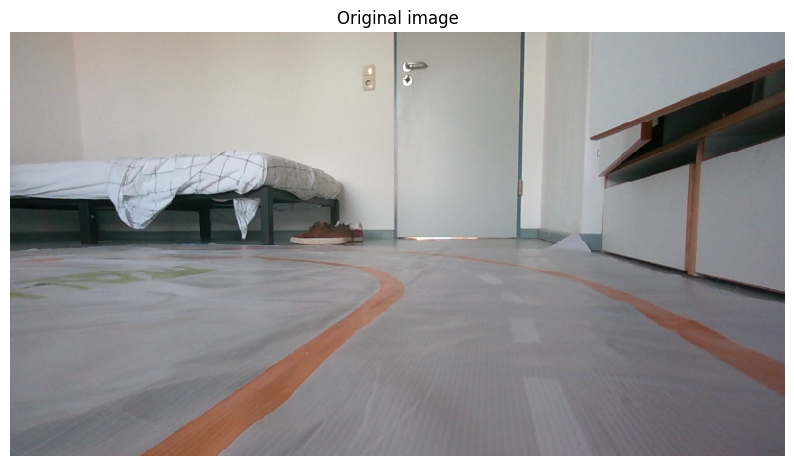

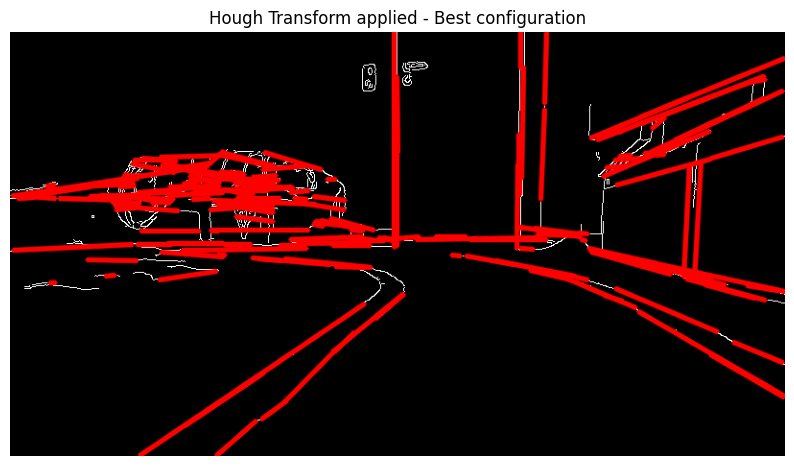

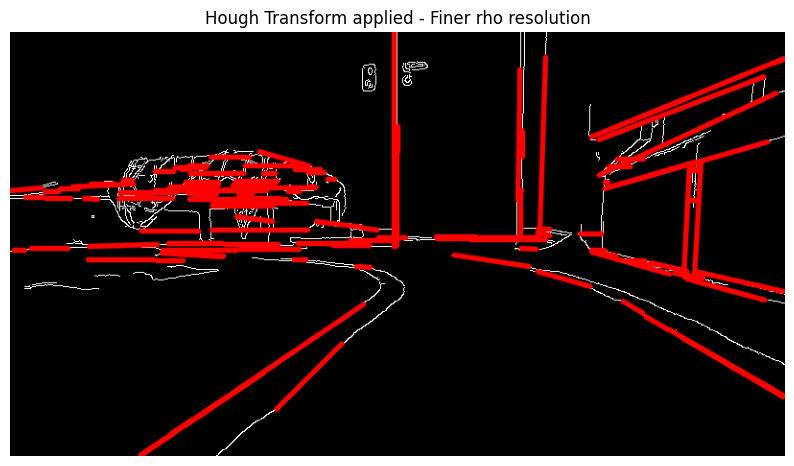

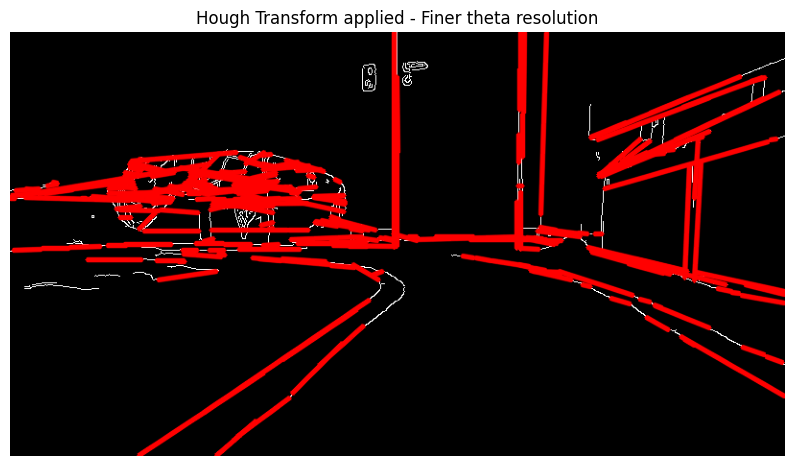

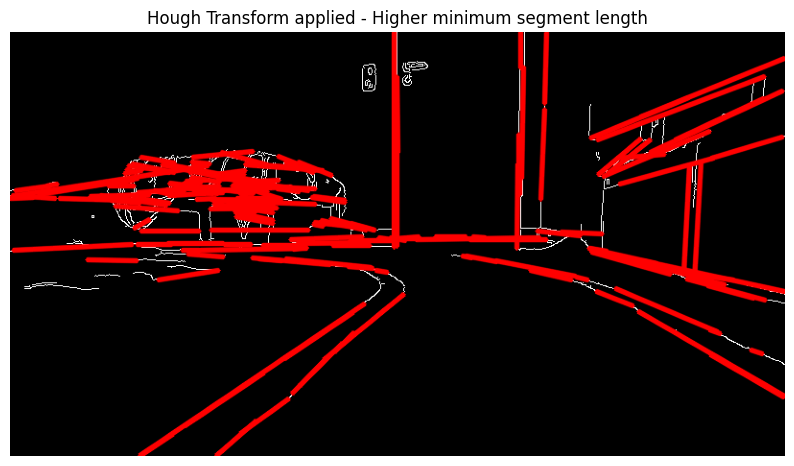

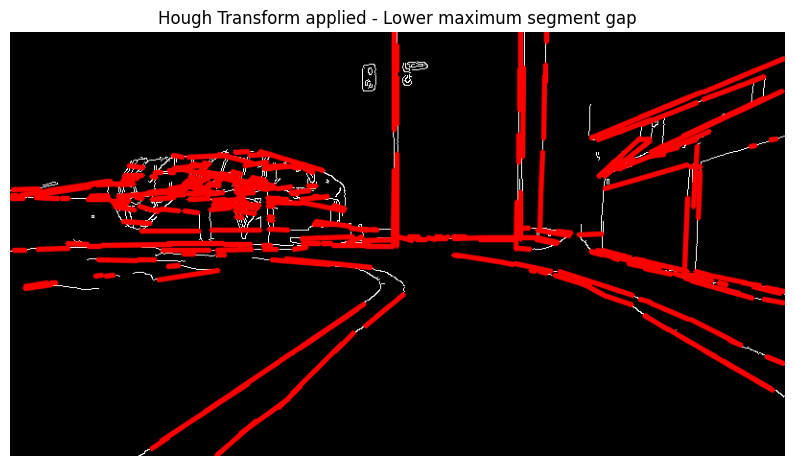

In [83]:
def HoughTransformP(img, rho, theta, threshold, minSegLength, maxSegGap):

    # Apply probabilistic Hough transform
    linesP = cv2.HoughLinesP(img, rho, theta, threshold, None, minSegLength, maxSegGap)
    hough = img.copy()
    hough = cv2.cvtColor(hough, cv2.COLOR_GRAY2BGR)

    #
    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(hough, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

    return hough

hough_base = HoughTransformP(canny_base, 1, np.pi/180, 50, 5, 10)
hough_1 = HoughTransformP(canny_base, 0.5, np.pi/180, 50, 5, 10)
hough_2 = HoughTransformP(canny_base, 1, np.pi/360, 50, 5, 10)
hough_3 = HoughTransformP(canny_base, 1, np.pi/180, 50, 10, 10)
hough_4 = HoughTransformP(canny_base, 1, np.pi/180, 50, 5, 5)

display_image(src, 'Original image')
display_image(hough_base, 'Hough Transform applied - Best configuration')
display_image(hough_1, 'Hough Transform applied - Finer rho resolution')
display_image(hough_2, 'Hough Transform applied - Finer theta resolution')
display_image(hough_3, 'Hough Transform applied - Higher minimum segment length')
display_image(hough_4, 'Hough Transform applied - Lower maximum segment gap')

Despite achieving more satisfactory results, this function proved to be highly inefficient in filtering out noise - lane pixels were removed when the base parameters were changed so that a finer filtering would take place, with the persistence of unintended detections. The canny edge/Hough transform image processing was thus discarded in favor of a more adequate approach.

### Image segmentation approach

The other solution developed in parallel with the canny edge/Hough transform method consisted of an implementation of image segmentation. This was done by firstly designating a specific area of the image in front of the robot (instead of the whole image to avoid as much noise as possible) and then running an algorithm for identifying pixels with a color within a desired range. This allows the partial segmentation of the image into two different regions corresponding to each of the lane limits. The same approach could not be applied to the centerline, whose color is very similar to the rest of the track and thus, in some lighting conditions, is undetectable. To solve this problem, the centroid of each of these regions was calculated using the k-means clustering method [7] and, by averaging the coordinates from both, the estimated centerline point was found.

In the following block, the required functions for this procedure can be found, followed by the processing of an example image.

In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os


def load_image(image_name, path='./images/'):
    image_path = f'{path}{image_name}.jpg'
    image = cv2.imread(image_path)
    assert image is not None, f"Image not found: {image_path}"
    return image


def display_image(image, title="Image", cmap=None):
    plt.figure(figsize=(10, 6))
    if cmap:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()


# Define desired region of the image to be segmented

def get_roi_mask(shape):
    h, w = shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    pts = np.array([[
        (int(0 * w), h), (int(0.99 * w), h),
        (int(0.9 * w), int(0.6 * h)),
        (int(0.2 * w), int(0.6 * h))
    ]], dtype=np.int32)
    cv2.fillPoly(mask, pts, 255)
    return mask


# Create mask according to desired color range

def extract_lane_mask(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([3, 70, 100])
    upper_yellow = np.array([15, 180, 200])
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask


# Apply mask to image

def find_lane_points(mask, y_start_ratio=0.75, y_end_ratio=0.87):
    h, w = mask.shape
    start_y = int(y_start_ratio * h)
    end_y = int(y_end_ratio * h)
    row_band = mask[start_y:end_y, :]
    ys, xs = np.where(row_band > 0)
    ys += start_y
    return xs, ys, start_y, end_y


# Graphic representation of detected pixels superimposed to the original image

def draw_lane_points(image, xs, ys, start_y, end_y):
    output = image.copy()
    for x, y in zip(xs, ys):
        cv2.circle(output, (x, y), 2, (0, 0, 255), -1)
    cv2.rectangle(output, (0, start_y), (image.shape[1], end_y), (255, 0, 0), 1)
    return output


# Find centroids of each cluster, determine center point and superimpose to original image

def apply_kmeans(image, xs, ys, n_clusters=2):
    output = image.copy()
    points = np.column_stack((xs, ys))

    if len(points) >= n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(points)
        centers = kmeans.cluster_centers_.astype(int)

        # Draw centroids in green
        for cx, cy in centers:
            cv2.circle(output, (cx, cy), 6, (0, 255, 0), -1)

        if len(centers) == 2:
            # Compute and draw center point in blue
            center_x = (centers[0][0] + centers[1][0]) // 2
            center_y = (centers[0][1] + centers[1][1]) // 2
            print(f"Center point between centroids: ({center_x}, {center_y})")
            cv2.circle(output, (center_x, center_y), 6, (255, 0, 0), -1)
        else:
            print("Warning: Expected 2 centroids but got a different number.")
    else:
        print("Not enough points for K-Means.")

    return output

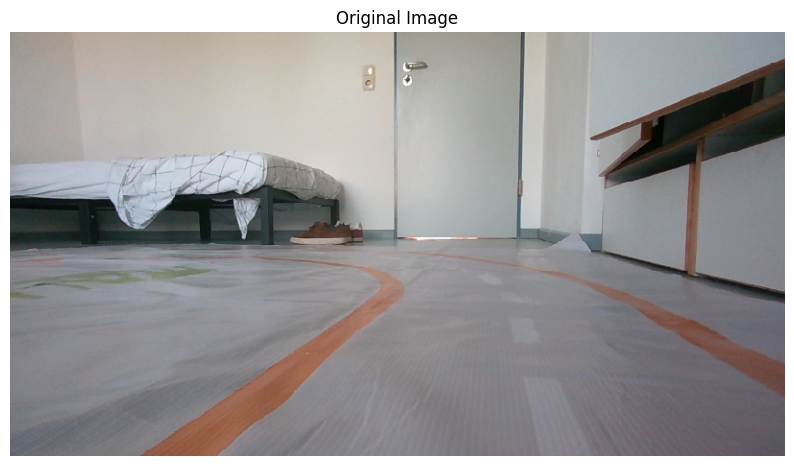

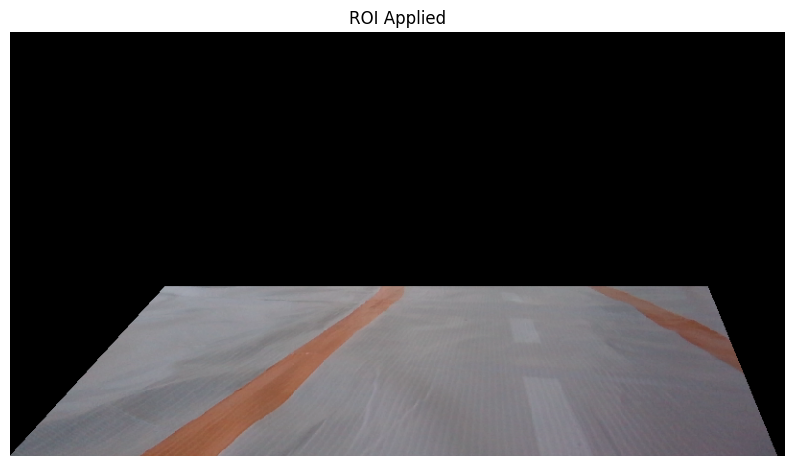

NameError: name 'extract_yellow_lane_mask' is not defined

In [85]:
image = load_image('image_raw_example')

display_image(image, "Original Image")

roi_mask = get_roi_mask(image.shape)
roi_image = cv2.bitwise_and(image, image, mask=roi_mask)
display_image(roi_image, "ROI Applied")

mask = extract_yellow_lane_mask(roi_image)
display_image(mask, "Yellow Mask + Morphology", cmap='gray')

xs, ys, start_y, end_y = find_lane_points(mask)

lane_img = draw_lane_points(image, xs, ys, start_y, end_y)
display_image(lane_img, "Detected Yellow Lane Points")

final_img = apply_kmeans(lane_img, xs, ys)
display_image(final_img, "K-Means Lane Centroids")

This method showed good results and provided some basic information for the robot to locate itself (even if one of the lanes was not detected or outside the field of vision, it would be possible for the robot to know its distance to the track limit).

### Creating discrete objects for the whole domain

The next approach would be to implement this method using IPM-transformed images as input, covering the whole image in order to provide information on a wider area of the track and therefore output two discrete objects, each of them describing an individual lane. The main idea involves dividing the image into a grid and determining the centroid of the detected pixels in each of the cells by using the same k-means function, if the pixel count reaches a determined threshold. This threshold is set to a value high enough so that false detections are avoided, without eliminating a significant number of positive occurences.

Some of the functions used previously were thus adapted and a new script was developed, using a similar approach:

In [86]:
# Updated mask to cover the whole domain

def get_roi_mask(shape):
    h, w = shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    pts = np.array([[
        (0, h), (w, h), (w, 0), (0, 0)
        ]], dtype=np.int32)
    cv2.fillPoly(mask, pts, 255)
    return mask


# Apply mask to a specific grid cell

def find_lane_points(mask, x_start_ratio, x_end_ratio, y_start_ratio, y_end_ratio):
    h, w = mask.shape
    start_x = int(x_start_ratio * w)
    end_x = int(x_end_ratio * w)
    start_y = int(y_start_ratio * h)
    end_y = int(y_end_ratio * h)
    grid_cell = mask[start_y:end_y, start_x:end_x]
    ys, xs = np.where(grid_cell > 0)
    xs += start_x
    ys += start_y
    return xs, ys, start_x, end_x, start_y, end_y


# Draw detected lane points and boundaries of the grid cell

def draw_lane_points(image, xs, ys, start_x, end_x, start_y, end_y):
    output = image.copy()
    for x, y in zip(xs, ys):
        cv2.circle(output, (x, y), 2, (0, 0, 255), -1)
    cv2.rectangle(output, (start_x, start_y), (end_x, end_y), (255, 0, 0), 1)
    return output


# Similar to apply_kmeans(), with only one cluster and applied to a single cell's domain

def apply_kmeans_grid(image, xs, ys, x_div, y_div):
    output = image.copy()
    points = np.column_stack((xs, ys))
    if len(points) >= image.shape[0]/y_div * image.shape[1]/x_div / 12:
        kmeans = KMeans(n_clusters=1, random_state=0, n_init=10).fit(points)
        centers = kmeans.cluster_centers_.astype(int)
        for cx, cy in centers:
            cv2.circle(output, (cx, cy), 6, (0, 255, 0), -1)
    else:
        centers = []
    return output, centers


def distSort(element):
    return element[0][1]

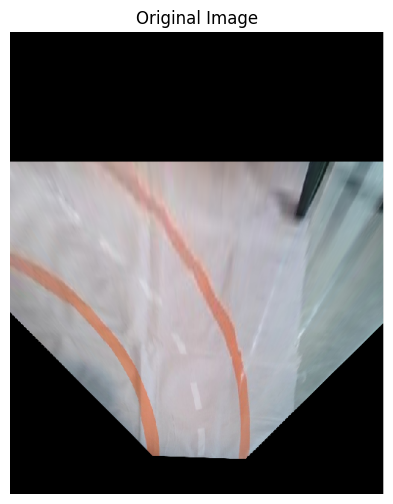

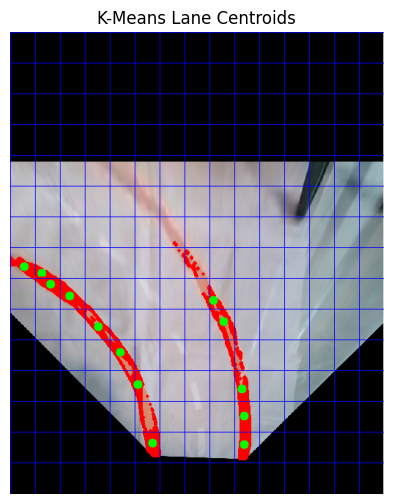

In [87]:
image = cv2.imread('images/lane_ipm.jpg', cv2.IMREAD_COLOR)
display_image(image, "Original Image")
original_image = image.copy()

roi_mask = get_roi_mask(image.shape)
roi_image = cv2.bitwise_and(image, image, mask=roi_mask)

mask = extract_lane_mask(roi_image)

cones = []

# Number of grid cells in each dimension
x_div = 15
y_div = 15

for x in range(x_div):
    for y in range(y_div):

        # Calculate the cell's corner's coordinates

        x_start_ratio = x/x_div
        x_end_ratio = (x+1)/x_div
        y_start_ratio = y/y_div
        y_end_ratio = (y+1)/y_div


        # Find the lane points and centroids

        xs, ys, start_x, end_x, start_y, end_y = find_lane_points(mask, x_start_ratio, x_end_ratio, y_start_ratio, y_end_ratio)

        image = draw_lane_points(image, xs, ys, start_x, end_x, start_y, end_y)

        image, centers = apply_kmeans_grid(image, xs, ys, x_div, y_div)

        if len(centers) > 0: cones.append(centers)

display_image(image, "K-Means Lane Centroids")

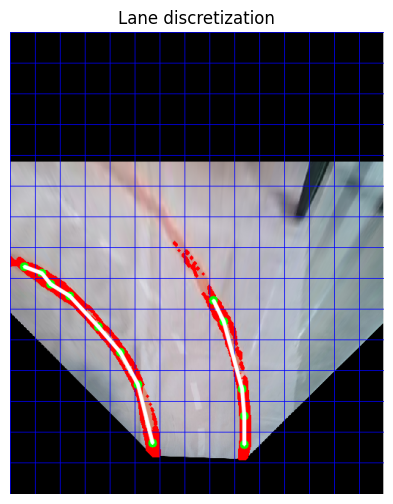

In [88]:
# Sort centroids according to y-coordinate
cones.sort(key=distSort)

final_lane = 255*np.ones((image.shape[0],image.shape[1],3), np.uint8)


# Draw connecting lines between adjacent centroids

for x in range(len(cones)):

    mindist = 999
    index = 0

    # Find closest non-connected centroid

    for y in range(len(cones)):
        if y != 0:
            dist = np.sqrt((cones[0][0][0]-cones[y][0][0])**2 + (cones[0][0][1]-cones[y][0][1])**2)
            if mindist > dist:
                mindist = dist
                index = y

    # Avoid connection between elements of different lanes (append if distance is coherent)

    if mindist < 2*np.sqrt((image.shape[0]/y_div)**2+(image.shape[1]/x_div)**2):
        cv2.line(image, cones[0][0], cones[index][0], (255,255,255), 3, cv2.LINE_AA)
        cv2.line(final_lane, cones[0][0], cones[index][0], (0,0,0), 3, cv2.LINE_AA)

    # Eliminate centroid from list to avoid repeated connection

    cones.pop(0)

display_image(image, "Lane discretization")
final_lane = cv2.cvtColor(final_lane, cv2.COLOR_BGR2GRAY)

### Creating a centerline object

Since the dotted line marking the centerline of the track has a similar color to the remainder of the circuit, it is difficult to detect it through the previous approach of image segmentation. The latter enables, however, the creation of a centerline object through image erosion. The idea is to dilate the previously detect lines in steps (a certain element is used to expand the object in each step) and, after each dilation, a check is done to detect pixels where the two dilations overlap. Finally, the image's borders are cropped to eliminate noise due to frequent overlaps in these regions.

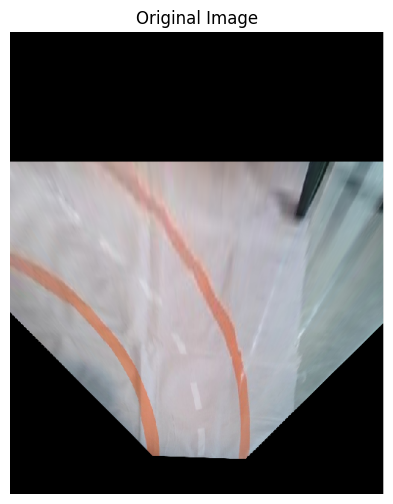

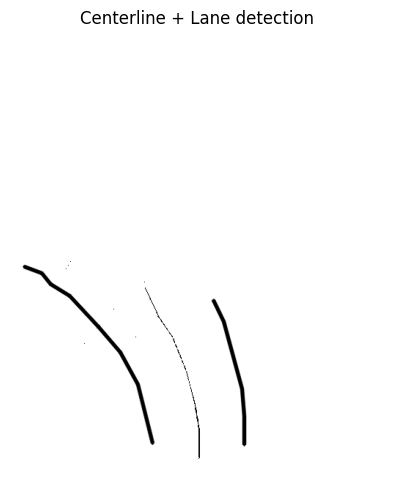

In [89]:
def centerLine(img):
    kernel = np.ones((20,20), np.uint8)
    img = cv2.erode(img, kernel, iterations=2)
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)

    ret,img = cv2.threshold(img,127,255,0)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False


    # Progressively erode image and detect overlaps between contours

    while(not done):
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()
        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True

    return skel

center_line = 255 - centerLine(final_lane)


# Remove noise through elimination of the image border areas

center_line[:,int(0.85*center_line.shape[1]):center_line.shape[1]] = 255
center_line[:,:int(0.15*center_line.shape[1])] = 255
center_line[:int(0.02*center_line.shape[0]),:] = 255
center_line[int(0.98*center_line.shape[0]):center_line.shape[0],:] = 255

# Combine results

final_output = cv2.bitwise_and(final_lane, center_line)

display_image(original_image, "Original Image")
display_image(final_output, "Centerline + Lane detection")

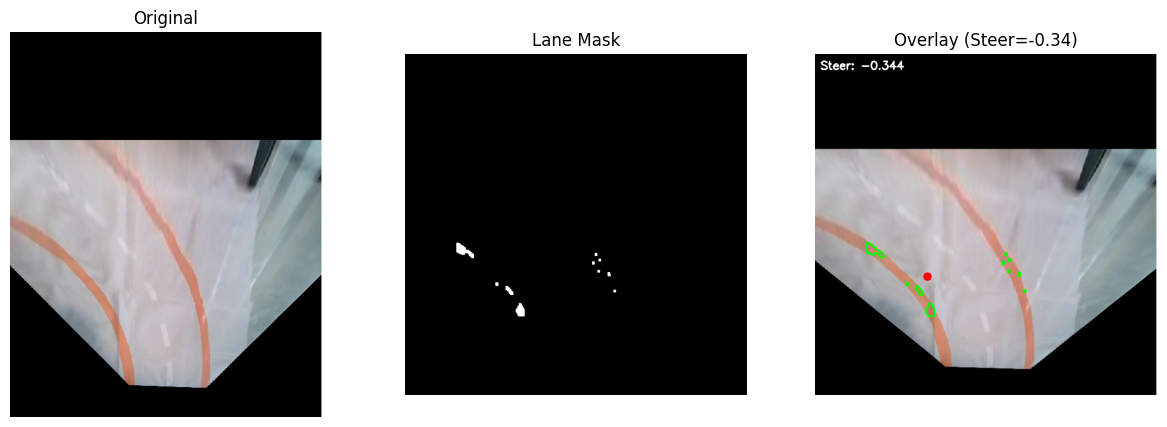

In [90]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class SimpleLaneDetector:
    def __init__(self):
        self.target_size = (640, 640)
        self.hsv_yellow_lower = (3, 70, 100)
        self.hsv_yellow_upper = (15, 180, 200)

        # ROI polygon (normalized)
        roi_norm = [(0.15, 0.77), (0.75, 0.77), (0.75, 0.35), (0.15, 0.35)]
        w, h = self.target_size
        self.roi_polygon = np.array([(int(nx * w), int(ny * h)) for nx, ny in roi_norm], dtype=np.int32)

    def process_image(self, img_bgr):
        if img_bgr is None:
            raise ValueError("Empty image")

        # resize
        frame = cv2.resize(img_bgr, self.target_size)

        # mask ROI
        mask = np.zeros(frame.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [self.roi_polygon], 255)
        roi = cv2.bitwise_and(frame, frame, mask=mask)

        # HSV threshold for yellow
        hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
        lane_mask = cv2.inRange(hsv, self.hsv_yellow_lower, self.hsv_yellow_upper)

        # morphology
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        lane_mask = cv2.morphologyEx(lane_mask, cv2.MORPH_OPEN, kernel)
        lane_mask = cv2.morphologyEx(lane_mask, cv2.MORPH_CLOSE, kernel)

        # find contours
        contours, _ = cv2.findContours(lane_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        overlay = frame.copy()
        steering_angle = 0.0

        if contours:
            cv2.drawContours(overlay, contours, -1, (0, 255, 0), 2)

            # compute lane center
            all_pts = np.vstack(contours).squeeze()
            mean_x = int(np.mean(all_pts[:, 0]))
            mean_y = int(np.mean(all_pts[:, 1]))
            cv2.circle(overlay, (mean_x, mean_y), 8, (0, 0, 255), -1)

            # simple steering: deviation from image center
            img_center = frame.shape[1] // 2
            steering_angle = (mean_x - img_center) / img_center

        # annotate overlay
        cv2.putText(
            overlay,
            f"Steer: {steering_angle:.3f}",
            (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (255, 255, 255),
            2,
        )

        return steering_angle, overlay, lane_mask


# --- Example usage --- #
detector = SimpleLaneDetector()
img = cv2.imread("images/lane_ipm.jpg")  # make sure path and filename are correct
if img is None:
    raise FileNotFoundError("Image not found. Check path!")

steer, overlay, mask = detector.process_image(img)

# show results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.title("Lane Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Overlay (Steer={steer:.2f})")
plt.axis("off")

plt.show()


# Conclusion

The project highlights that hardware choices and software architecture are tightly coupled: algorithmic choices must respect compute and sensor constraints for practical deployment. There is no single universal solution; instead, robust system design is about selecting a set of complementary tools (classical vision for speed, selective learned components for robustness) and engineering dependable calibration, logging and testing processes. As automotive compute resources rise, more sophisticated perception models will become feasible on embedded platforms, but carefully engineered lightweight approaches remain relevant for education, rapid prototyping and constrained deployments. The lessons learned from the scaled platform can guide both teaching and research and form a practical bridge to full-scale autonomous vehicle development.


Here is the implementation of the image processing pipeline on ROS. The following steps were carried out using a single BEV image obtained from the Inverse Perspective Mapping (after tuning the IPM). These steps also provide detailed insights for debugging and parameter tuning:

* **BEV Input** – base image after IPM tuning
* **ROI Masking** – restrict processing to lane-relevant region
* **Color Thresholding (HSV) + Morphology** – extract lane pixels, remove noise
* **Sobel X Gradient** – compute edge weights for lane boundary emphasis
* **Sliding Window Search** – detect lane pixels, apply quadratic fit for curvature estimation (R)
* **Centerline & Deviation** – calculate lateral offset and steering-induced shift → total deviation
* **Drive Command Computation** – steering angle & speed derived from deviation using controller
* **Actuation** – final commands sent to the vehicle

![Image Processing Pipeline: From BEV Input to Vehicle Actuation](./data/5.png)

In the upcoming cells, each stage of this procedure is presented in detail for inspection, debugging, and parameter tuning.



## Environment & requirements

Python 3.8+, packages:
- numpy
- opencv-python
- matplotlib
- pyyaml (only if using YAML)

Install with:
```
pip install numpy opencv-python matplotlib pyyaml
```


### 1. Parameters

In [91]:
# ============================================================
# Lane Detection Pipeline Parameters
# ============================================================
# This block defines all important parameters for the image
# processing and lane detection pipeline. These parameters
# correspond to what will later be configured in `lane.yaml`.
# They control aspects such as:
#   - Input image and resizing
#   - ROI masking
#   - HSV color thresholding and morphological filtering
#   - Sobel edge detection
#   - Sliding window search and polynomial fitting
#   - Lane centerline, lookahead region, and deviation estimation
#   - Output directory for saving results
#
# Each parameter will be described in detail in the following
# cells when relevant for debugging, visualization, or tuning.
# ============================================================


PARAMS = {
    'target_width': 640,
    'target_height': 640,
    'input_path': './data/000040.jpg',            # set to 'path/to/your/image.jpg' or None to use synthetic image
    'roi_poly_norm': [(0.15,0.80),(0.70,0.80),(0.70,0.20),(0.15,0.20)],
    'hsv_lower': (2, 50, 80),
    'hsv_upper': (25, 255, 255),
    'morph_kernel': 5,
    'morph_iterations': 1,
    'sobel_ksize': 3,
    'sobel_percentile': 90,
    'sobel_fixed_thresh': 20,
    'alpha_color': 0.83,
    'beta_sobel': 0.17,
    'fusion_threshold': 0.18,
    'win_count': 10,
    'win_half_width': 35,
    'win_min_pixels': 10,
    'win_start_y': 510,
    'win_end_y': 256,
    'poly_degree': 2,
    'lookahead_xmin': 305,
    'lookahead_xmax': 335,
    'lookahead_ymin': 200,
    'lookahead_ymax': 480,
    'hist_peak_min_value': 5,
    'min_lane_distance': 140,
    'min_win_half': 8,
    'center_point_count': 12,
    'strip_min_points': 10,
    'output_dir': 'outputs'
}

import os
os.makedirs(PARAMS['output_dir'], exist_ok=True)
print('PARAMS set. Edit this block to change pipeline behavior.')

PARAMS set. Edit this block to change pipeline behavior.


<!-- # ## Environment & requirements
#
# Python 3.8+, packages:
# - numpy
# - opencv-python
# - matplotlib
# - pyyaml (only if using YAML)
#
# Install with:
# ```
# pip install numpy opencv-python matplotlib pyyaml
# ``` -->


## 2. Helper Functions  

This section defines a set of utility functions that are used throughout the image processing pipeline.  
They support common operations such as visualization, masking, thresholding, and curve fitting.  
By defining them here, we can keep the main pipeline code cleaner and focus on the step-by-step logic.  


In [92]:
from typing import Tuple, List, Optional, Dict, Any
import cv2, numpy as np, os, math

def get_input_image(params: Dict[str, Any]) -> np.ndarray:
    """Load an input image (BGR). If no path is provided, generate a synthetic example."""
    W = params['target_width']; H = params['target_height']
    path = params.get('input_path', None)
    if path and os.path.exists(path):
        img = cv2.imread(path)
        return cv2.resize(img, (W,H), interpolation=cv2.INTER_LINEAR)
    # synthetic fallback
    return synthetic_birdseye(W, H, curvature=0.0008)

def resize_img(img: np.ndarray, params: Dict[str, Any]) -> np.ndarray:
    return cv2.resize(img, (params['target_width'], params['target_height']), interpolation=cv2.INTER_LINEAR)

def build_roi_mask_from_norm(poly_norm: List[Tuple[float,float]], W:int, H:int) -> Tuple[np.ndarray, np.ndarray]:
    pts = []
    for x,y in poly_norm:
        pts.append([int(x*W), int(y*H)])
    mask = np.zeros((H, W), dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(pts, dtype=np.int32)], 255)
    return mask, np.array(pts, dtype=np.int32)

def synthetic_birdseye(w=640, h=640, curvature=0.0008) -> np.ndarray:
    img = np.zeros((h, w, 3), dtype=np.uint8) + 40
    ys = np.linspace(0, h-1, h).astype(int)
    cx = w//2; lane_offset = int(0.22*w)
    left_pts=[]; right_pts=[]
    for y in ys:
        dx = int(curvature * (y - h/2)**2)
        left_pts.append((cx - lane_offset + dx, y)); right_pts.append((cx + lane_offset + dx, y))
    cv2.polylines(img, [np.array(left_pts, dtype=np.int32)], False, (10,120,120), thickness=6)
    cv2.polylines(img, [np.array(right_pts, dtype=np.int32)], False, (10,120,120), thickness=6)
    return img

def hsv_lane_mask(img_bgr: np.ndarray, lower: Tuple[int,int,int], upper: Tuple[int,int,int], morph_k:int=5, morph_iter:int=1) -> Tuple[np.ndarray, np.ndarray]:
    """Return (mask (0/255 uint8), hsv image)."""
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    lower_np = np.array(lower, dtype=np.uint8); upper_np = np.array(upper, dtype=np.uint8)
    mask = cv2.inRange(hsv, lower_np, upper_np)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_k, morph_k))
    if morph_iter>0:
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k, iterations=morph_iter)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k, iterations=morph_iter)
    return mask, hsv

def sobel_x_magnitude(img_bgr: np.ndarray, ksize: int=3) -> np.ndarray:
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32)
    sx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=ksize)
    return np.abs(sx)

def normalize_to_8u(arr: np.ndarray) -> np.ndarray:
    arr = arr.astype(np.float32); mx = arr.max() if arr.max()>0 else 1.0
    return np.clip((arr/mx)*255.0,0,255).astype(np.uint8)

def to_nonzero_xy(mask: np.ndarray) -> np.ndarray:
    """Return Nx2 int array of (x,y) for nonzero mask pixels (mask is 0/255 uint8)."""
    nz = cv2.findNonZero(mask)
    if nz is None: return np.zeros((0,2), dtype=int)
    return np.array([[int(p[0][0]), int(p[0][1])] for p in nz], dtype=int)



def compute_base_anchors_from_binary(final_binary: np.ndarray,
                                     hist_peak_min_value: float,
                                     min_lane_distance: int,
                                     win_half_width: int,
                                     bottom_frac: float = 1.0/3.0,
                                     morph_kernel: int = 5,
                                     morph_iters: int = 1,
                                     debug: bool = False,
                                     adapt_threshold_if_too_high: bool = True):
    """
    Compute left/right base x anchors and presence flags using only final_binary.
    final_binary: uint8 binary image with values {0,1} or {0,255}.
    hist_peak_min_value:
        - if 0 < value <= 1: interpreted as fraction of bottom window height (recommended),
        - else interpreted as absolute pixel count (0..rb_h).
    min_lane_distance: minimum expected separation between lanes (pixels).
    win_half_width: half-width for smoothing window (kernel size = 2*win_half_width+1, min 3).
    bottom_frac: portion of image height to use from the bottom (default 1/3).
    morph_kernel: if >0, apply morphological open+close with this kernel size to reduce noise.
    morph_iters: number of morphology iterations.
    Returns: ( (left_x, right_x), (useLeft, useRight) )
    """
    # normalize binary to 0/1
    if final_binary.dtype != np.uint8:
        final_binary = final_binary.astype(np.uint8)
    fb = final_binary.copy()
    # if values are 0/255 -> convert to 0/1
    if fb.max() > 1:
        fb = (fb > 0).astype(np.uint8)

    h, w = fb.shape[:2]

    # sanitize bottom_frac
    bottom_frac = float(bottom_frac)
    if bottom_frac <= 0 or bottom_frac > 1:
        bottom_frac = 1.0/3.0

    rb_h = max(10, int(np.clip(h * bottom_frac, 1, h)))  # bottom region height to use
    bottom = fb[h - rb_h : h, :]  # shape (rb_h, w)

    # optional morphological denoise (helps in noisy binarizations)
    if morph_kernel and morph_kernel > 1:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_kernel, morph_kernel))
        bottom = cv2.morphologyEx(bottom.astype(np.uint8), cv2.MORPH_OPEN, k, iterations=morph_iters)
        bottom = cv2.morphologyEx(bottom, cv2.MORPH_CLOSE, k, iterations=morph_iters)

    # column counts (units: pixels in bottom window)
    colcount = bottom.sum(axis=0).astype(float)  # range [0, rb_h]

    # smoothing kernel: ensure odd kernel size at least 3
    if win_half_width <= 0:
        kernel_size = 3
    else:
        kernel_size = max(3, 2 * int(win_half_width) + 1)
    kernel = np.ones(kernel_size, dtype=float) / kernel_size
    smoothv = np.convolve(colcount, kernel, mode='same')

    mid = w // 2
    left_region = smoothv[:mid] if mid > 0 else np.array([])
    right_region = smoothv[mid:] if mid > 0 else np.array([])

    bestL = int(np.argmax(left_region)) if left_region.size else -1
    bestR = (int(np.argmax(right_region)) + mid) if right_region.size else -1

    maxL = float(smoothv[bestL]) if bestL >= 0 else 0.0
    maxR = float(smoothv[bestR]) if bestR >= 0 else 0.0
    overall_max = float(smoothv.max()) if smoothv.size else 0.0

    # interpret threshold
    if 0 < hist_peak_min_value <= 1.0:
        thresh = hist_peak_min_value * rb_h
    else:
        thresh = float(hist_peak_min_value)

    # adapt threshold if user supplied ridiculous value
    if adapt_threshold_if_too_high and overall_max > 0 and thresh > overall_max:
        old_thresh = thresh
        thresh = max(1.0, 0.5 * overall_max)
        if debug:
            print(f"[threshold adapt] supplied {old_thresh:.2f} > observed max {overall_max:.2f}; lowered to {thresh:.2f}")

    useLeft = (bestL >= 0) and (maxL >= thresh)
    useRight = (bestR >= 0) and (maxR >= thresh)

    # if both detected but too close, keep the stronger one
    if useLeft and useRight and (bestR - bestL) < min_lane_distance:
        if maxL > maxR:
            useRight = False
        else:
            useLeft = False

    if debug:
        print("---- compute_base_anchors_from_binary debug ----")
        print(f"image w,h: {w},{h}   bottom_frac: {bottom_frac}   rb_h: {rb_h}")
        print(f"kernel_size: {kernel_size}")
        print(f"bestL: {bestL}  maxL (smoothed count): {maxL:.2f}")
        print(f"bestR: {bestR}  maxR (smoothed count): {maxR:.2f}")
        print(f"overall_max: {overall_max:.2f}  thresh: {thresh:.2f}")
        if bestL >= 0:
            lslice = smoothv[max(0, bestL-3): min(w, bestL+4)]
            print(f"left neigh (idx {max(0,bestL-3)}..{min(w,bestL+4)-1}): {lslice}")
        if bestR >= 0:
            rslice = smoothv[max(0, bestR-3): min(w, bestR+4)]
            print(f"right neigh (idx {max(0,bestR-3)}..{min(w,bestR+4)-1}): {rslice}")
        print(f"useLeft: {useLeft}  useRight: {useRight}")
        print("-----------------------------------------------")

    # fallback anchors if neither present
    if not useLeft and not useRight:
        halfsep = max(1, min(w // 4, min_lane_distance // 2))
        l0 = max(0, mid - halfsep)
        r0 = min(w - 1, mid + halfsep)
        return (l0, r0), (False, False)

    # both found
    if useLeft and useRight:
        return (bestL, bestR), (True, True)

    # only left
    if useLeft:
        bestR_est = min(w - 1, bestL + min_lane_distance)
        return (bestL, bestR_est), (True, False)

    # only right
    bestL_est = max(0, bestR - min_lane_distance)
    return (bestL_est, bestR), (False, True)



def sliding_windows_from_mask(mask: np.ndarray, nonzero_pts: np.ndarray, baseX: Tuple[int,int], config: Dict[str,Any]):
    h,w = mask.shape[:2]
    win_count = config['win_count']
    win_start = config['win_start_y']; win_end = config['win_end_y']
    if win_start <= win_end:
        win_start = h-1; win_end = int(h/4)
    vertical_span = max(1, win_start - win_end)
    win_h = max(1, vertical_span // max(1, win_count))
    win_y_low = []; win_y_high = []
    for i in range(win_count):
        low = int(max(0, win_start - (i+1)*win_h + 1))
        high = int(min(h-1, win_start - i*win_h))
        win_y_low.append(low); win_y_high.append(high)
    nonzero = nonzero_pts
    window_centroids = {0: [], 1: []}
    lane_idxs = {0: [], 1: []}
    currX = [int(baseX[0]), int(baseX[1])]
    for level in range(win_count):
        ylow = win_y_low[level]; yhigh = win_y_high[level]
        cy = (ylow + yhigh)//2
        candidates = []
        for seed_side in [0,1]:
            winHalf = max(config['min_win_half'], config['win_half_width'])
            xcenter = currX[seed_side]
            xlow = max(0, xcenter - winHalf); xhigh = min(w-1, xcenter + winHalf)
            if nonzero.size == 0: continue
            mask_idx = np.where((nonzero[:,1] >= ylow) & (nonzero[:,1] <= yhigh) & (nonzero[:,0] >= xlow) & (nonzero[:,0] <= xhigh))[0]
            if mask_idx.size == 0: continue
            xs = nonzero[mask_idx,0]
            if xs.size >= config['win_min_pixels']:
                newX = int(np.round(xs.mean()))
                candidates.append({'seed': seed_side, 'idxs': mask_idx.tolist(), 'newX': newX, 'weight': xs.size})
        if len(candidates) == 0:
            window_centroids[0].append((currX[0], cy)); window_centroids[1].append((currX[1], cy))
            continue
        if len(candidates) == 1:
            cand = candidates[0]
            side = cand['seed']
            lane_idxs[side].extend(cand['idxs'])
            currX[side] = cand['newX']
            window_centroids[side].append((currX[side], cy))
            window_centroids[1-side].append((currX[1-side], cy))
            continue
        centers = [currX[0], currX[1]]
        for it in range(6):
            groups = {0: [], 1: []}
            for i,c in enumerate(candidates):
                d0 = abs(c['newX'] - centers[0]); d1 = abs(c['newX'] - centers[1])
                assign = 0 if d0 <= d1 else 1
                groups[assign].append(c)
            new_centers = []
            for g in [0,1]:
                if len(groups[g])==0:
                    new_centers.append(centers[g])
                else:
                    s = sum([t['newX']*t['weight'] for t in groups[g]]); wtot = sum([t['weight'] for t in groups[g]])
                    new_centers.append(int(round(s/wtot)))
            centers = new_centers
        clustered = {0: {'idxs':[],'cx':centers[0]}, 1:{'idxs':[],'cx':centers[1]}}
        for i,c in enumerate(candidates):
            d0 = abs(c['newX'] - centers[0]); d1 = abs(c['newX'] - centers[1])
            assign = 0 if d0 <= d1 else 1
            clustered[assign]['idxs'].extend(c['idxs'])
        for side in [0,1]:
            if len(clustered[side]['idxs'])==0:
                window_centroids[side].append((currX[side], cy))
            else:
                xs = nonzero[clustered[side]['idxs'],0]
                if xs.size>0:
                    newX = int(round(xs.mean()))
                    currX[side] = newX
                    lane_idxs[side].extend(clustered[side]['idxs'])
                    window_centroids[side].append((newX, cy))
                else:
                    window_centroids[side].append((currX[side], cy))
    lane_idxs[0] = sorted(set(lane_idxs[0])); lane_idxs[1] = sorted(set(lane_idxs[1]))
    return window_centroids, lane_idxs

def fit_poly_from_points(points_xy: List[Tuple[float,int]], deg: int=2) -> Optional[np.ndarray]:
    if points_xy is None or len(points_xy) < 2: return None
    xs = np.array([p[0] for p in points_xy]); ys = np.array([p[1] for p in points_xy])
    try:
        coeffs = np.polyfit(ys, xs, deg)
        return coeffs
    except Exception:
        return None

def eval_poly(coeffs: np.ndarray, y: float) -> Optional[float]:
    if coeffs is None: return None
    p = np.poly1d(coeffs); return float(p(y))

def curvature_from_poly(coeffs: np.ndarray, y_eval: float) -> float:
    if coeffs is None: return 0.0
    a = coeffs[0] if len(coeffs)>=1 else 0.0; b = coeffs[1] if len(coeffs)>=2 else 0.0
    dx = 2*a*y_eval + b; d2x = 2*a
    denom = abs(d2x) if abs(d2x)>1e-6 else 1e-6
    R = (1.0 + dx*dx)**1.5 / denom
    return (1.0/R) if R>0 else 0.0

import numpy as np
import math

def compute_center_polyline(window_centroids: Dict[int, List[Tuple[int,int]]], config: Dict[str,Any]) -> List[Tuple[float,int]]:
    n_points = config.get('center_point_count', 12)
    y_min = 270
    y_max = 506#config.get('lookahead_ymax', 480)
    ys = [int(y_min + (y_max-y_min)*(i/(n_points-1))) if n_points>1 else int((y_min+y_max)/2) for i in range(n_points)]
    left = window_centroids[0]; right = window_centroids[1]
    def interp(centroids, y):
        if len(centroids)==0: return None
        ys_c = np.array([p[1] for p in centroids]); xs_c = np.array([p[0] for p in centroids])
        if y <= ys_c.min(): return float(xs_c[ys_c.argmin()])
        if y >= ys_c.max(): return float(xs_c[ys_c.argmax()])
        for i in range(len(ys_c)-1):
            if ys_c[i] <= y <= ys_c[i+1] or ys_c[i+1] <= y <= ys_c[i]:
                y0,y1 = ys_c[i], ys_c[i+1]; x0,x1 = xs_c[i], xs_c[i+1]
                if y1==y0: return float(x0)
                t = (y - y0)/(y1-y0); return float(x0 + t*(x1-x0))
        return float(xs_c.mean())
    center_pts = []
    for y in ys:
        lx = interp(left, y); rx = interp(right, y)
        if lx is None and rx is None:
            cx = config['target_width']/2.0
        elif lx is None:
            best_l = rx - config['min_lane_distance']; cx = (best_l + rx)/2.0
        elif rx is None:
            best_r = lx + config['min_lane_distance']; cx = (lx + best_r)/2.0
        else:
            cx = (lx + rx)/2.0
        center_pts.append((float(cx), int(y)))
    return center_pts



def compute_theta_from_strips(side_points: Dict[int, List[Tuple[int,int]]], config: Dict[str,Any]) -> Tuple[float, Tuple[List[int],List[int]]]:
    lx0 = config['lookahead_xmin']; lx1 = config['lookahead_xmax']; ly0 = config['lookahead_ymin']; ly1 = config['lookahead_ymax']
    box_h = max(1, ly1-ly0+1); strip_h = max(1, box_h//3)
    strips = [(ly0, ly0+strip_h-1), (ly0+strip_h, ly0+2*strip_h-1), (ly0+2*strip_h, ly1)]
    countsL = [0,0,0]; countsR = [0,0,0]
    for (x,y) in side_points.get(0,[]):
        for si,sb in enumerate(strips):
            if sb[0] <= y <= sb[1]: countsL[si]+=1; break
    for (x,y) in side_points.get(1,[]):
        for si,sb in enumerate(strips):
            if sb[0] <= y <= sb[1]: countsR[si]+=1; break
    left_ok = any([c>=config.get('strip_min_points', 10) for c in countsL])
    right_ok = any([c>=config.get('strip_min_points', 10) for c in countsR])
    theta = 0.0
    if not left_ok and not right_ok:
        theta = 0.0
    elif left_ok and not right_ok:
        theta = config.get('theta_l2', -1.0)
    elif not left_ok and right_ok:
        theta = config.get('theta_r2', 1.0)
    else:
        left_strength = countsL[2]*3 + countsL[1]*2 + countsL[0]*1
        right_strength= countsR[2]*3 + countsR[1]*2 + countsR[0]*1
        theta = config.get('theta_r2', 1.0) if right_strength>left_strength else config.get('theta_l2', -1.0)
    return theta, (countsL, countsR)

def compute_desired_speed(theta: float, center_confidence: float, config: Dict[str,Any]) -> float:
    steer_mag = abs(theta)
    any_detect = center_confidence > 0.05
    if not any_detect:
        desired = config.get('no_lane_speed', 0.38)
    else:
        desired = max(0.0, 0.45 - min(0.12, steer_mag * 0.08))
    conf_scale = 0.5 + 0.5 * center_confidence
    desired *= conf_scale
    desired = max(0.0, min(desired, 10.0))
    return desired

print('Helpers loaded.')

Helpers loaded.


### 3. Preprocessing: resize, rotate (optional) and ROI extraction

What this step does:
- Ensures images are a fixed working resolution (reduces variability and runtime).
- Builds a binary ROI mask from normalized polygon coordinates so later steps only run on the road region.

Parameters:
- `target_width`, `target_height`: final image size in pixels.
- `roi_poly_norm`: list of (x_norm, y_norm) coordinates between 0..1 describing the polygon.

Effect of parameter changes:
- Increasing resolution (`target_width/height`) improves spatial accuracy at cost of compute time.
- Changing `roi_poly_norm` redefines which pixels are considered; too small: valid lane pixels removed; too large: more noise enters.

Diagnostics:
- Inspect three images inline: original, resized, and rotated (if used).
- Inspect overlay: your ROI polygon rendered on the resized image.


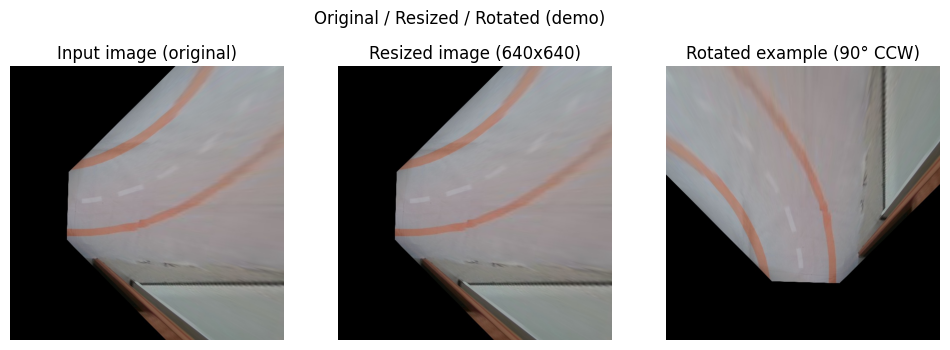

True

In [93]:
# Load image
img = get_input_image(PARAMS)
img_resized = resize_img(img, PARAMS)
H,W = img_resized.shape[:2]
ROI_MASK, ROI_POLY_PTS = build_roi_mask_from_norm(PARAMS['roi_poly_norm'], W, H)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title('Input image (original)'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)); plt.title(f'Resized image ({W}x{H})'); plt.axis('off')
img = cv2.rotate(img_resized, cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title('Rotated example (90° CCW)'); plt.axis('off')
plt.suptitle('Original / Resized / Rotated (demo)')
plt.show()
cv2.imwrite(os.path.join(PARAMS['output_dir'], 'image_resized.png'), img_resized[:,:,::-1])


### ROI overlay
 Shows ROI polygon overlay and extracted ROI image.

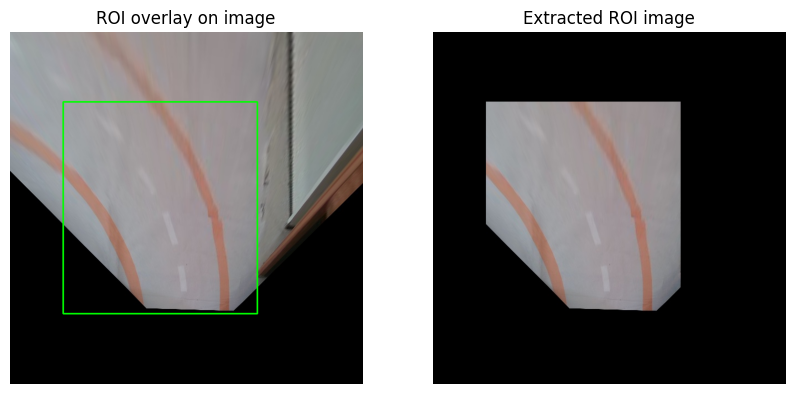

True

In [94]:
ov = img.copy()
cv2.polylines(ov, [ROI_POLY_PTS], isClosed=True, color=(0,255,0), thickness=2)
img = cv2.bitwise_and(img, img, mask=ROI_MASK)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(ov, cv2.COLOR_BGR2RGB)); plt.title('ROI overlay on image'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title('Extracted ROI image'); plt.axis('off')
plt.show()
cv2.imwrite(os.path.join(PARAMS['output_dir'], 'roi_overlay.png'), ov[:,:,::-1])
cv2.imwrite(os.path.join(PARAMS['output_dir'], 'roi_extracted.png'), img[:,:,::-1])


### 4. HSV conversion — H,S,V channels & histograms

What this step does:
- Converts the image to OpenCV HSV (H range 0..179).
- Shows the H, S, V channels and their histograms. This helps choose `hsv_lower` and `hsv_upper`.

Parameters:
- `hsv_lower` and `hsv_upper`: tuples (H,S,V) in OpenCV ranges.

How parameter changes affect output:
- Narrower H range reduces false positives (e.g., road markings of other colors) but may miss faded paint.
- Raising `S` minimum removes desaturated (grey/white) portions; may remove pale lane paint.
- Raising `V` minimum removes dark shadow regions.

Diagnostics:
- H histogram: look for peaks corresponding to lane paint hue.
- Inspect S and V histograms to avoid thresholds that cut off the lane cluster.
- Example: if lane hue appears as H~10..30, set `hsv_lower[0]` slightly lower and `hsv_upper[0]` slightly higher than that cluster.


### HSV conversion — channels & histograms
 Shows H,S,V channels + histograms (OpenCV H range: 0–179)

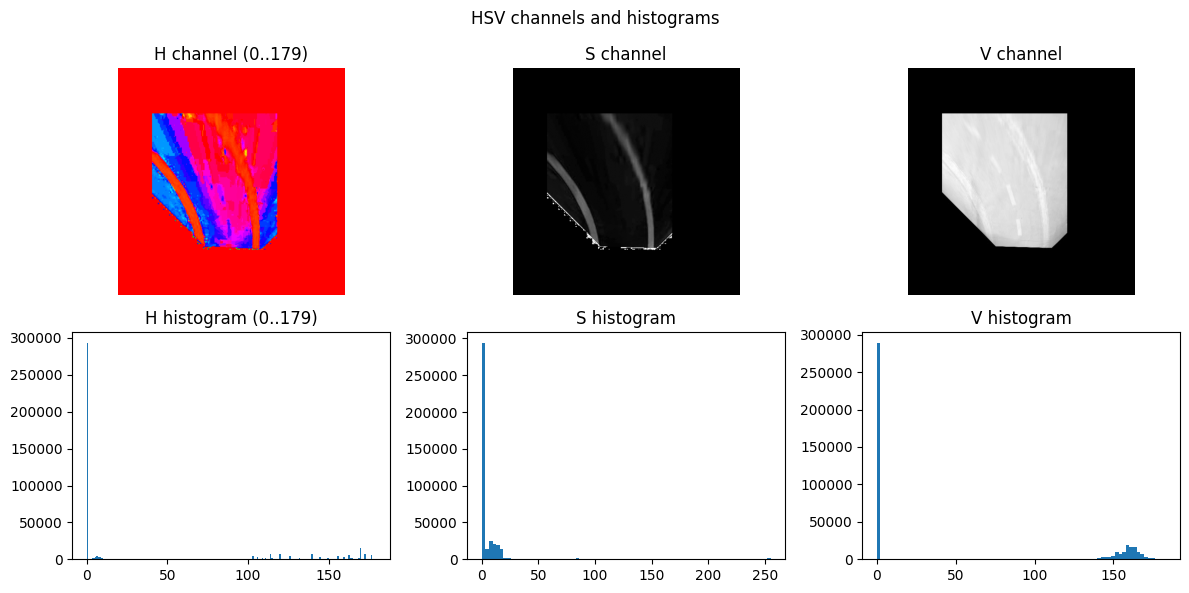

True

In [95]:
mask, hsv = hsv_lane_mask(img, PARAMS['hsv_lower'], PARAMS['hsv_upper'],
                          morph_k=PARAMS['morph_kernel'], morph_iter=PARAMS['morph_iterations'])
Hch,Sch,Vch = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]

plt.figure(figsize=(12,6))
plt.subplot(2,3,1); plt.imshow(Hch, cmap='hsv'); plt.title('H channel (0..179)'); plt.axis('off')
plt.subplot(2,3,2); plt.imshow(Sch, cmap='gray'); plt.title('S channel'); plt.axis('off')
plt.subplot(2,3,3); plt.imshow(Vch, cmap='gray'); plt.title('V channel'); plt.axis('off')
plt.subplot(2,3,4); plt.hist(Hch.ravel(), bins=180, range=(0,179)); plt.title('H histogram (0..179)')
plt.subplot(2,3,5); plt.hist(Sch.ravel(), bins=80); plt.title('S histogram')
plt.subplot(2,3,6); plt.hist(Vch.ravel(), bins=80); plt.title('V histogram')
plt.suptitle('HSV channels and histograms'); plt.tight_layout(); plt.show()
cv2.imwrite(os.path.join(PARAMS['output_dir'],'h_channel.png'), normalize_to_8u(Hch))
cv2.imwrite(os.path.join(PARAMS['output_dir'],'s_channel.png'), normalize_to_8u(Sch))
cv2.imwrite(os.path.join(PARAMS['output_dir'],'v_channel.png'), normalize_to_8u(Vch))


### 5. HSV thresholding — Show multiple parameter sets side-by-side

What this step does:
- Applies several HSV ranges (nominal, narrower-H, wider-S) and displays:
  - binary mask (0/255)
  - overlay on original
  - histogram of selected pixels' H values

Parameters:
- The candidate sets are examples — to tune, edit the sets and rerun this cell.

How changes affect output:
- `narrowH` will be more selective — fewer but more pure lane pixels.
- `widerS` will accept more desaturated pixels (may add false positives from road surface).

Diagnostics:
- Inspect overlays to check whether lane paint pixels are captured and background is rejected.
- Inspect H histogram for each mask to make sure mask picks a coherent H cluster.


### HSV thresholding — three parameter sets side-by-side
 For each: binary mask, overlay, H histogram of selected pixels

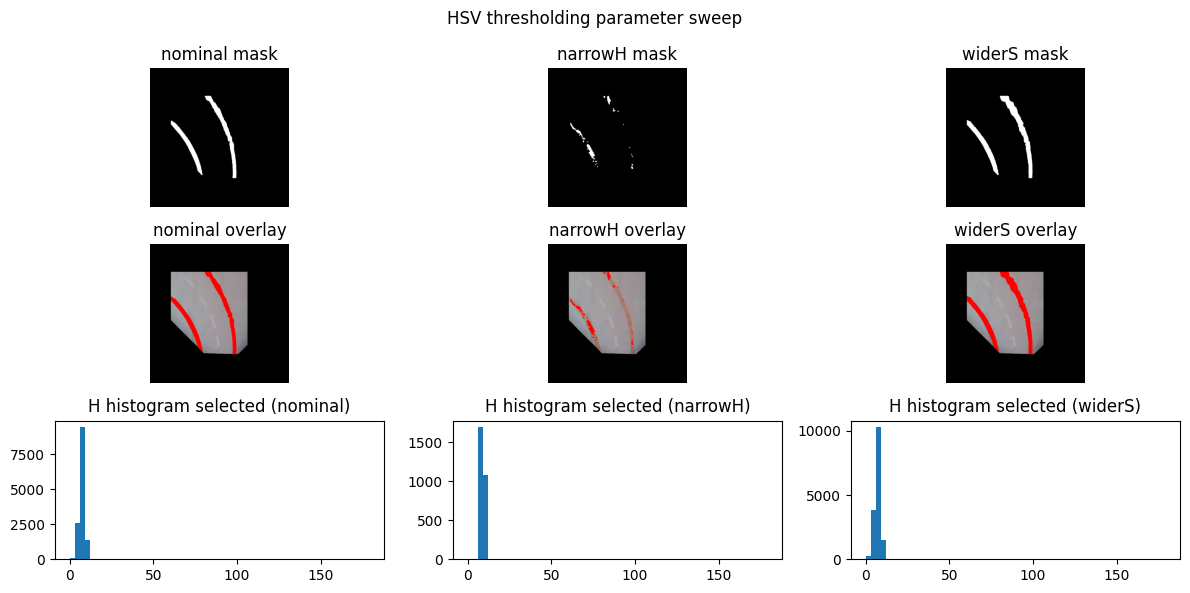

In [96]:
# %%
candidates = [
    ('nominal', PARAMS['hsv_lower'], PARAMS['hsv_upper']),
    ('narrowH', (max(0,PARAMS['hsv_lower'][0]+6), PARAMS['hsv_lower'][1], PARAMS['hsv_lower'][2]), (min(179,PARAMS['hsv_upper'][0]-4), PARAMS['hsv_upper'][1], PARAMS['hsv_upper'][2])),
    ('widerS', (PARAMS['hsv_lower'][0], max(0,PARAMS['hsv_lower'][1]-20), PARAMS['hsv_lower'][2]), (PARAMS['hsv_upper'][0], 255, PARAMS['hsv_upper'][2]))
]

import matplotlib.pyplot as plt
n = len(candidates)
plt.figure(figsize=(4*n,6))
for i,(name,low,high) in enumerate(candidates):
    msk, hsv_local = hsv_lane_mask(img, low, high,
                                   morph_k=PARAMS['morph_kernel'], morph_iter=PARAMS['morph_iterations'])
    overlay = img.copy(); overlay[msk>0] = [0,0,255]
    plt.subplot(3,n,i+1); plt.imshow(msk, cmap='gray'); plt.title(f'{name} mask'); plt.axis('off')
    plt.subplot(3,n,n+i+1); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title(f'{name} overlay'); plt.axis('off')
    plt.subplot(3,n,2*n+i+1); plt.hist(hsv_local[:,:,0][msk>0].ravel(), bins=60, range=(0,179)); plt.title(f'H histogram selected ({name})')
plt.suptitle('HSV thresholding parameter sweep'); plt.tight_layout(); plt.show()


### 6. Morphological cleaning: opening / closing / erosion / dilation comparisons

What this step does:
- Demonstrates how different kernels and iteration counts change the mask.
- Helps remove speckle and fill short gaps in mask.

Parameters:
- `morph_kernel` (odd integer): kernel size for structuring element.
- `morph_iterations`: number of morphology iterations.

How changes affect output:
- Larger `morph_kernel` removes smaller noisy blobs but may erode thin true positives.
- Increasing `morph_iterations` amplifies the effect.
- Typical workflow: small opening (kernel=3) to remove speckle, then closing (kernel=5) to fill gaps.

Diagnostics:
- Visual comparison of original mask, eroded, dilated, opened, closed for two kernel choices.
- If true lane lines appear broken after opening, reduce kernel or iterations; if mask contains many small speckles, increase opening kernel.


### Morphological cleaning: original, eroded, dilated, opened, closed — two kernel sizes
 Compare how kernel size and iterations change results.


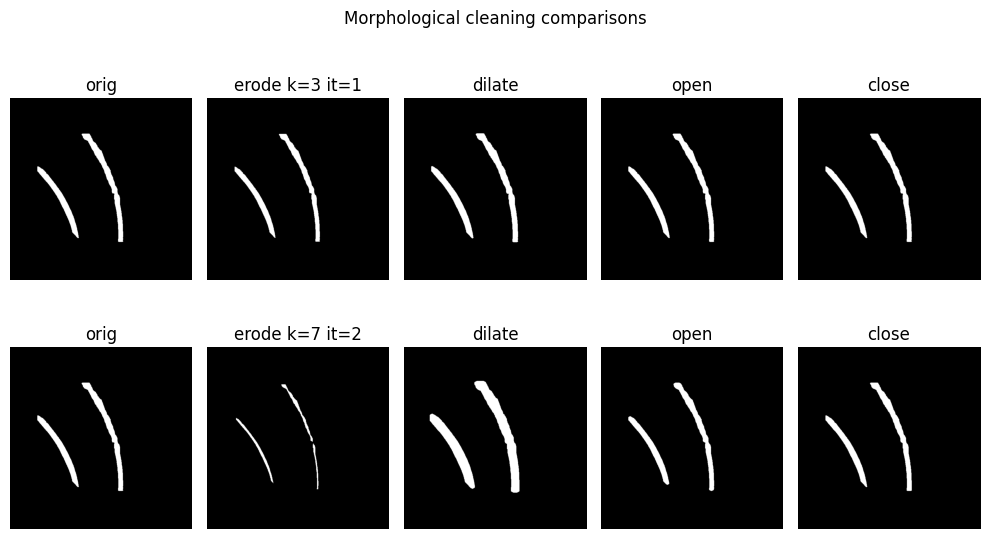

In [97]:
kernels = [(3,1),(7,2)]
plt.figure(figsize=(10,6))
for i,(k,it) in enumerate(kernels):
    k_el = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k,k))
    opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k_el, iterations=it)
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k_el, iterations=it)
    eroded = cv2.erode(mask, k_el, iterations=it)
    dilated = cv2.dilate(mask, k_el, iterations=it)
    plt.subplot(len(kernels),5,i*5+1); plt.imshow(mask, cmap='gray'); plt.title('orig'); plt.axis('off')
    plt.subplot(len(kernels),5,i*5+2); plt.imshow(eroded, cmap='gray'); plt.title(f'erode k={k} it={it}'); plt.axis('off')
    plt.subplot(len(kernels),5,i*5+3); plt.imshow(dilated, cmap='gray'); plt.title('dilate'); plt.axis('off')
    plt.subplot(len(kernels),5,i*5+4); plt.imshow(opened, cmap='gray'); plt.title('open'); plt.axis('off')
    plt.subplot(len(kernels),5,i*5+5); plt.imshow(closed, cmap='gray'); plt.title('close'); plt.axis('off')
plt.suptitle('Morphological cleaning comparisons'); plt.tight_layout(); plt.show()



### 6. Sobel edge analysis — Gx, Gy (abs), gradient magnitude, thresholds

What this step does:
- Computes Sobel X (we focus on X for vertical/lane edges), normalizes to 8-bit and produces candidate thresholds: fixed, percentile, Otsu.

Parameters:
- `sobel_ksize` (1,3,5,7): filter kernel for derivative.
- `sobel_percentile`: use this percentile on normalized Sobel to generate a binary edge mask.
- `sobel_fixed_thresh`: alternative fixed threshold.

How changes affect output:
- Larger `sobel_ksize` smooths noise (reduce spurious edges) but blurs sharp edges.
- Higher `sobel_percentile` → fewer strong edges kept.

Diagnostics:
- View raw Sobel abs, normalized 8-bit image, histogram & thresholded masks (fixed / percentile / Otsu).
- If lane edges are missing, lower percentile or ksize; if too noisy, raise percentile or increase ksize.


### Sobel edge analysis: Gx magnitude, norm, histogram, and threshold candidates


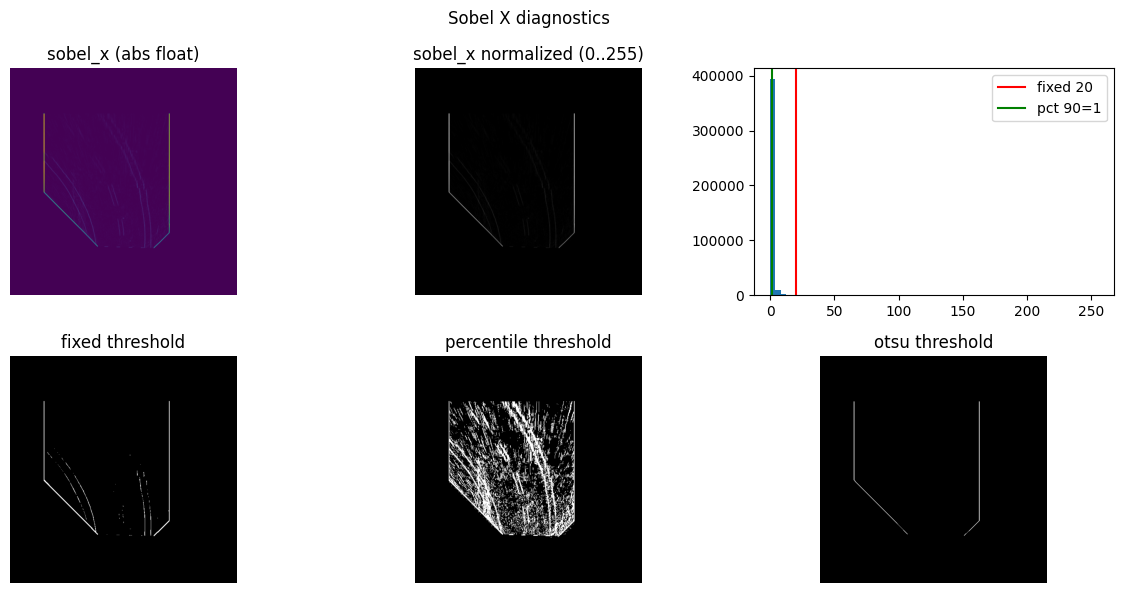

True

In [98]:
sx = sobel_x_magnitude(img, ksize=PARAMS['sobel_ksize'])
sx8 = normalize_to_8u(sx)
fixed_T = PARAMS['sobel_fixed_thresh']
percentile_T = int(np.percentile(sx8.flatten(), PARAMS['sobel_percentile']))
otsu_T, otsu_bin = cv2.threshold(sx8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

sobel_mask_fixed = (sx8 > fixed_T).astype(np.uint8) * 255
sobel_mask_pct = (sx8 > percentile_T).astype(np.uint8) * 255
sobel_mask_otsu = otsu_bin

plt.figure(figsize=(12,6))
plt.subplot(2,3,1); plt.imshow(sx, cmap='viridis'); plt.title('sobel_x (abs float)'); plt.axis('off')
plt.subplot(2,3,2); plt.imshow(sx8, cmap='gray'); plt.title('sobel_x normalized (0..255)'); plt.axis('off')
plt.subplot(2,3,3); plt.hist(sx8.ravel(), bins=64); plt.axvline(fixed_T, color='r', label=f'fixed {fixed_T}'); plt.axvline(percentile_T, color='g', label=f'pct {PARAMS["sobel_percentile"]}={percentile_T}'); plt.legend()
plt.subplot(2,3,4); plt.imshow(sobel_mask_fixed, cmap='gray'); plt.title('fixed threshold'); plt.axis('off')
plt.subplot(2,3,5); plt.imshow(sobel_mask_pct, cmap='gray'); plt.title('percentile threshold'); plt.axis('off')
plt.subplot(2,3,6); plt.imshow(sobel_mask_otsu, cmap='gray'); plt.title('otsu threshold'); plt.axis('off')
plt.suptitle('Sobel X diagnostics'); plt.tight_layout(); plt.show()

cv2.imwrite(os.path.join(PARAMS['output_dir'], 'sobel_x.png'), sx8)
cv2.imwrite(os.path.join(PARAMS['output_dir'], 'sobel_mask_pct.png'), sobel_mask_pct)


### 7. Fused mask: color evidence (S) + sobel evidence; threshold sweep help

What this step does:
- Builds a soft `color_score` from the S channel masked by HSV mask and a normalized `sobel_score`.
- Fuses them with weights `alpha_color`, `beta_sobel` and thresholds `fusion_threshold`.
- Provides histogram and CDF for choosing a threshold.

Parameters:
- `alpha_color` / `beta_sobel`: weights for fusion (sum recommended ≈ 1)
- `fusion_threshold`: threshold on fused score to create final binary

How changes affect output:
- Increase `alpha_color` to favor color (good when lane color is reliable).
- Increase `beta_sobel` to favor edges (useful when color varies).
- Increase `fusion_threshold` to be more conservative (fewer false positives), decrease to include thin / faded lines.

Diagnostics:
- Plot: color_score, sobel_score, fused score, histogram and CDF with candidate thresholds (top 1/2/5/10% and Otsu).
- Choose threshold visually where fused-score CDF jumps from background to lane cluster.


### Combined binary used for detection: color-only, edges-only, fused combined
Show the color mask, the edge map and the combined result (overlay). Also show CDF & percentile candidates.


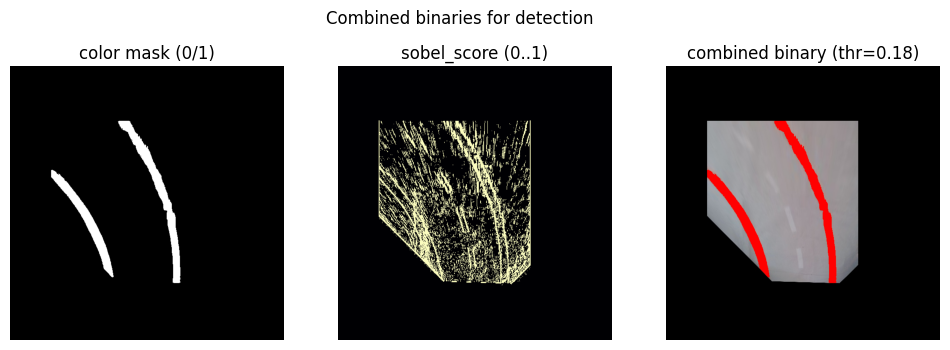

True

In [99]:
S = hsv[:,:,1].astype(np.float32)/255.0
color_binary = (mask>0).astype(np.uint8)
color_score = color_binary.astype(np.float32) * S
sobel_score = sobel_mask_pct.astype(np.float32)/255.0
alpha = PARAMS['alpha_color']; beta = PARAMS['beta_sobel']
fused_score = alpha*color_score + beta*sobel_score
thr = PARAMS['fusion_threshold']
final_binary = (fused_score >= thr).astype(np.uint8)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
#plt.subplot(1,3,1); plt.imshow(color_binary, cmap='gray'); plt.title('color mask (0/1)'); plt.axis('off')
plt.subplot(1,3,1); plt.imshow(final_binary, cmap='gray'); plt.title('color mask (0/1)'); plt.axis('off')

plt.subplot(1,3,2); plt.imshow(sobel_score, cmap='magma'); plt.title('sobel_score (0..1)'); plt.axis('off')
plt.subplot(1,3,3); ov = img.copy(); ov[final_binary>0] = [0,0,255]; plt.imshow(cv2.cvtColor(ov, cv2.COLOR_BGR2RGB)); plt.title(f'combined binary (thr={thr})'); plt.axis('off')
plt.suptitle('Combined binaries for detection'); plt.show()

# Save
cv2.imwrite(os.path.join(PARAMS['output_dir'], 'mask_color.png'), (color_binary*255).astype('uint8'))
cv2.imwrite(os.path.join(PARAMS['output_dir'], 'combined_binary.png'), (final_binary*255).astype('uint8'))


In [100]:
final_binary = (fused_score >= thr).astype(np.uint8)

### 8. Sliding-window detection — grids, centroid correction, base histogram, polynomial fit & overlays

What this step does:
- Uses the final binary to compute `nonzero_xy`.
- Finds base anchors from bottom-region histogram (left & right).
- Runs sliding-window search across `win_count` vertical windows to compute centroids.
- Fits polynomials x(y) for left and right sides and constructs a centerline.

Parameters:
- `win_count`: vertical number of windows.
- `win_half_width`: lateral half-width of each window’s search area.
- `win_min_pixels`: minimum pixels in a window to accept a centroid.
- `win_start_y`, `win_end_y`: start and end Y coordinates of search range (bottom -> top).

How changes affect output:
- Increasing `win_half_width` helps find centroids under larger lateral drift but risks associating to other lane.
- Increasing `win_min_pixels` rejects spurious tiny clusters.
- `win_count` controls vertical resolution of detections.

Diagnostics & plots required:
- Grid of boxes only (windows-only) across the image (no centroid recentring).
- After centroid correction: show centroid-centered boxes.
- Histogram used for finding base anchors (bottom region column sum).
- Visualize nonzero pixels used for fitting (color-coded L/R).
- Overlay polynomial fits and centerline(s) on original image.
- Show "windows-only" debug and "centroid-corrected + fit" images with legends.


### Sliding-window detection: windows-only, centroid-corrected, base histogram, nonzero points, polynomial fits, overlay.


In [101]:
final_binary_01 = (final_binary > 0).astype(np.uint8)

# (optional) convert to 0/255 if you still need that elsewhere:
final_binary_255 = (final_binary_01 * 255).astype(np.uint8)

# debug example call:
baseX, presence = compute_base_anchors_from_binary(
    final_binary_01,
    hist_peak_min_value=PARAMS['hist_peak_min_value'],
    min_lane_distance=PARAMS['min_lane_distance'],
    win_half_width=PARAMS['win_half_width'],
    bottom_frac=1.0/3.0,      # use bottom third as requested
    morph_kernel=5,           # optional: denoise
    morph_iters=1,
    debug=True,               # print internal values so you can see why a lane was rejected
    adapt_threshold_if_too_high=True
)

l_x, r_x = baseX
useL, useR = presence

nonzero_xy = to_nonzero_xy(final_binary_255)  # keep this if you still need 0..255 input

print("Left base x:", l_x)
print("Right base x:", r_x)
print("Use left lane:", useL)
print("Use right lane:", useR)


---- compute_base_anchors_from_binary debug ----
image w,h: 640,640   bottom_frac: 0.3333333333333333   rb_h: 213
kernel_size: 71
bestL: 206  maxL (smoothed count): 16.68
bestR: 362  maxR (smoothed count): 19.15
overall_max: 19.15  thresh: 5.00
left neigh (idx 203..209): [16.23943662 16.47887324 16.61971831 16.67605634 16.67605634 16.67605634
 16.67605634]
right neigh (idx 359..365): [16.77464789 17.85915493 18.74647887 19.15492958 19.15492958 19.15492958
 19.15492958]
useLeft: True  useRight: True
-----------------------------------------------
Left base x: 206
Right base x: 362
Use left lane: True
Use right lane: True


## Sliding Window Visualization

**Left Panel – Before:**

* Dashed boxes and triangles (`v`) show the initial window positions and centroids.
* **Cyan** = left window, **Magenta** = right window.

**Right Panel – After:**

* Solid boxes and circles (`o`) show the final, re-centered windows and centroids after sliding.
* Same color coding.


498


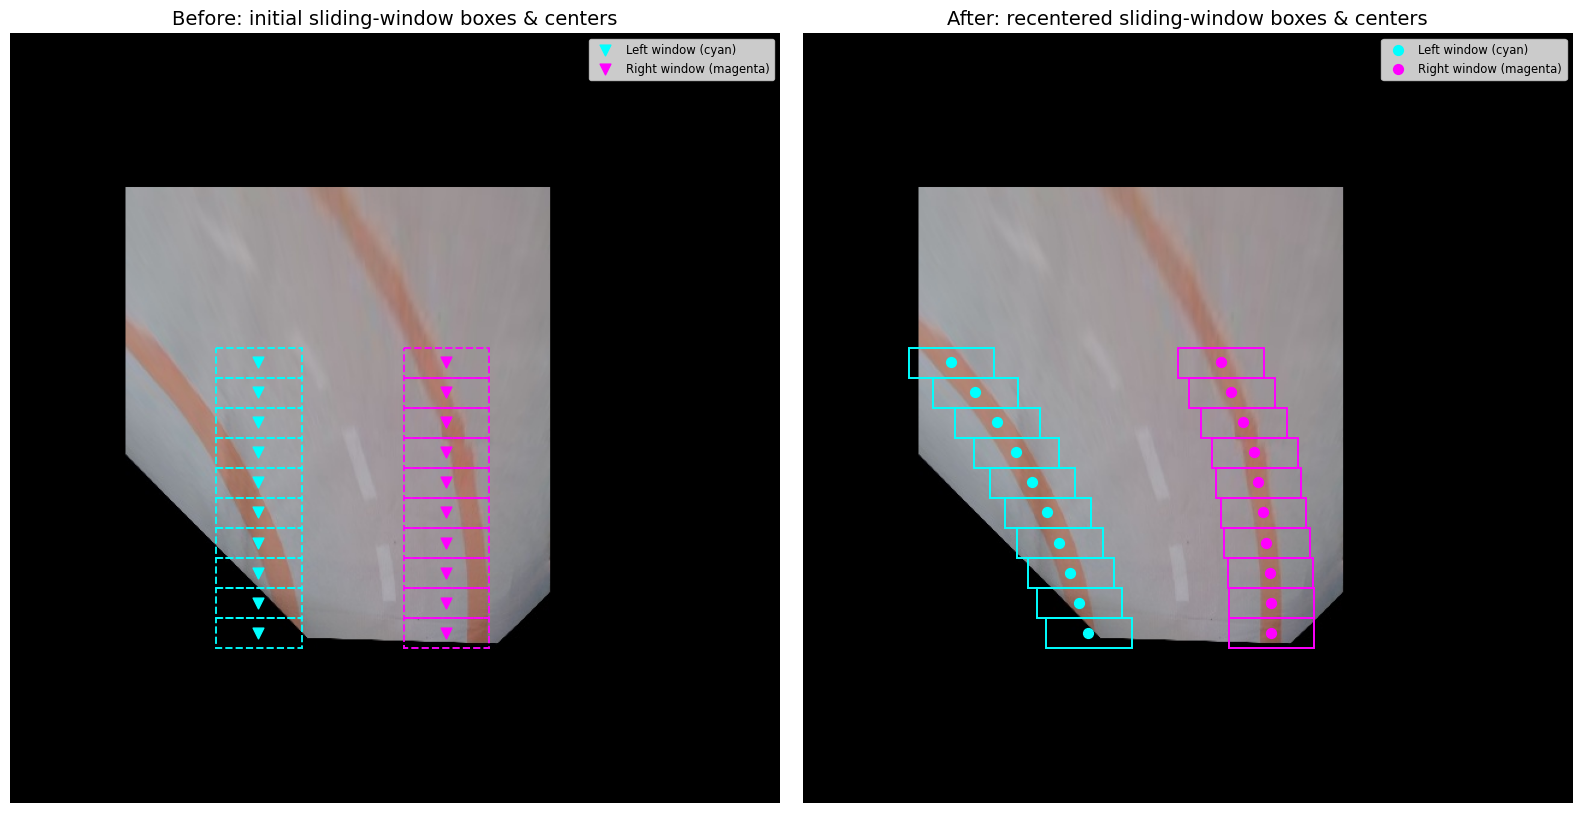

In [102]:

from matplotlib.patches import Rectangle

h, w = mask.shape[:2]
win_count = PARAMS['win_count']
win_start = PARAMS['win_start_y']; win_end = PARAMS['win_end_y']
if win_start <= win_end:
    win_start = h - 1
    win_end = int(h / 4)
vertical_span = max(1, win_start - win_end)
win_h = max(1, vertical_span // max(1, win_count))

# compute y ranges
win_y_low, win_y_high = [], []
for i in range(win_count):
    low = int(max(0, win_start - (i + 1) * win_h + 1))
    high = int(min(h - 1, win_start - i * win_h))
    win_y_low.append(low)
    win_y_high.append(high)
# bottommost window is level 0
ylow_bottom = win_y_low[0]
yhigh_bottom = win_y_high[0]

# centroid y of the bottom window
cy_bottom = (ylow_bottom + yhigh_bottom) // 2

print(cy_bottom)
# initial boxes/centers
init_centers, init_boxes = {0: [], 1: []}, {0: [], 1: []}
winHalf = max(PARAMS['min_win_half'], PARAMS['win_half_width'])
for level in range(win_count):
    ylow, yhigh = win_y_low[level], win_y_high[level]
    cy = (ylow + yhigh) // 2
    # left
    cxL = int(baseX[0])
    xlowL = max(0, cxL - winHalf)
    width = min(w - 1, cxL + winHalf) - xlowL + 1
    init_centers[0].append((cxL, cy))
    init_boxes[0].append((xlowL, ylow, width, yhigh - ylow + 1))
    # right
    cxR = int(baseX[1])
    xlowR = max(0, cxR - winHalf)
    widthR = min(w - 1, cxR + winHalf) - xlowR + 1
    init_centers[1].append((cxR, cy))
    init_boxes[1].append((xlowR, ylow, widthR, yhigh - ylow + 1))

# final sliding windows
window_centroids, lane_idxs = sliding_windows_from_mask(mask, nonzero_xy, baseX, PARAMS)
final_boxes, final_centers = {0: [], 1: []}, {0: [], 1: []}
for side in [0,1]:
    for lvl, centroid in enumerate(window_centroids[side]):
        cx, cy = centroid
        ylow, yhigh = win_y_low[lvl], win_y_high[lvl]
        xlow = max(0, int(cx) - winHalf)
        width = min(w - 1, int(cx) + winHalf) - xlow + 1
        final_boxes[side].append((xlow, ylow, width, yhigh - ylow + 1))
        final_centers[side].append((int(cx), int(cy)))

# --- Plot side-by-side ---
colors = {
    0: {'box':'cyan','centroid':'cyan', 'label':'Left window (cyan)'},
    1: {'box':'magenta','centroid':'magenta', 'label':'Right window (magenta)'}
}

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# LEFT: initial
ax = axs[0]
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.set_title('Before: initial sliding-window boxes & centers', fontsize=14)
ax.axis('off')

for side in [0,1]:
    for (x, y, width, height) in init_boxes[side]:
        rect = Rectangle((x, y), width, height, linewidth=1.4,
                         edgecolor=colors[side]['box'], facecolor='none',
                         linestyle='--', alpha=0.95)
        ax.add_patch(rect)
    xs = [c[0] for c in init_centers[side]]
    ys = [c[1] for c in init_centers[side]]
    ax.scatter(xs, ys, marker='v', s=60, c=colors[side]['centroid'],
               label=colors[side]['label'], zorder=5)

ax.legend(loc='upper right', fontsize='small')

# RIGHT: final
ax = axs[1]
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.set_title('After: recentered sliding-window boxes & centers', fontsize=14)
ax.axis('off')

for side in [0,1]:
    for (x, y, width, height) in final_boxes[side]:
        rect = Rectangle((x, y), width, height, linewidth=1.4,
                         edgecolor=colors[side]['box'], facecolor='none',
                         linestyle='-', alpha=1.0)
        ax.add_patch(rect)
    xs = [c[0] for c in final_centers[side]]
    ys = [c[1] for c in final_centers[side]]
    ax.scatter(xs, ys, marker='o', s=50, c=colors[side]['centroid'],
               label=colors[side]['label'], zorder=6)

ax.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()


Left poly coeffs: [-1.33939394e-03  1.53061212e+00 -1.94297055e+02]
Right poly coeffs: [-1.01818182e-03  9.67563636e-01  1.59066473e+02]


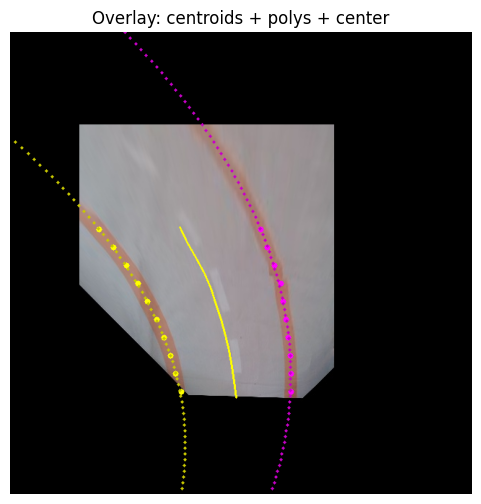

True

In [103]:
# Fit polynomials
left_coeffs = fit_poly_from_points(window_centroids[0], deg=PARAMS['poly_degree'])
right_coeffs = fit_poly_from_points(window_centroids[1], deg=PARAMS['poly_degree'])
print('Left poly coeffs:', left_coeffs); print('Right poly coeffs:', right_coeffs)

# overlay polylines
overlay = img.copy()
for (x,y) in window_centroids[0]: cv2.circle(overlay, (int(x),int(y)), 4, (0,255,255), -1)
for (x,y) in window_centroids[1]: cv2.circle(overlay, (int(x),int(y)), 4, (255,0,255), -1)

ys = np.arange(0,H)
if left_coeffs is not None:
    xsL = np.poly1d(left_coeffs)(ys).astype(int)
    for y in range(0,H,8):
        x = int(xsL[y]) if 0<=xsL[y]<W else None
        if x is not None and 0<=x<W: cv2.circle(overlay,(x,y),2,(0,200,200),-1)
if right_coeffs is not None:
    xsR = np.poly1d(right_coeffs)(ys).astype(int)
    for y in range(0,H,8):
        x = int(xsR[y]) if 0<=xsR[y]<W else None
        if x is not None and 0<=x<W: cv2.circle(overlay,(x,y),2,(200,0,200),-1)

center_poly = compute_center_polyline(window_centroids, PARAMS)
for i in range(len(center_poly)-1):
    x0,y0 = int(center_poly[i][0]), int(center_poly[i][1]); x1,y1 = int(center_poly[i+1][0]), int(center_poly[i+1][1])
    cv2.line(overlay, (x0,y0), (x1,y1), (0,255,255), 2)

plt.figure(figsize=(6,6)); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title('Overlay: centroids + polys + center'); plt.axis('off'); plt.show()
cv2.imwrite(os.path.join(PARAMS['output_dir'], 'final_overlay.png'), overlay[:,:,::-1])


### 9. Lane-Keeping Lateral Deviation Calculation (Pixels)

To compute the desired steering angle for lane keeping, we use simple **vehicle dynamics geometry** and a **lookahead point** along the lane centerline. The lookahead point (tunable) allows us to anticipate the lane curvature and adjust steering proactively.

The **total lateral deviation** at the lookahead point is calculated as the sum of three contributions:

1. **Current vehicle offset (`dy0`)**: the horizontal distance from the vehicle’s current center to the bottom/front centerline point.
2. **Curve-induced shift (`curve_px`)**: the horizontal displacement between the front centerline point and the lookahead point due to lane curvature.
3. **Steering-induced shift (`s_phi_px`)**: the lateral shift caused by the vehicle’s current steering angle (assumed 5° here).

The resulting **total deviation (`Delta_total_px`)** represents the control error for lane keeping. This deviation can then be used as the **target error** to compute the **desired steering angle** that keeps the vehicle centered in the lane.

All calculations are performed **purely in pixel coordinates**, with the image convention `(0,0)` at the top-left, `x` increasing to the right, and `y` increasing downward. The overlay visualization shows the centerline, front and lookahead points, and all deviations with arrows for clarity.
### Vehicle Dynamics Reference

Below are reference illustrations for the lane-keeping geometry[:

<table>
<tr>
<td><img src="./data/1.png" width="500"></td>
<td><img src="./data/2.png" width="500"></td>
</tr>
</table>



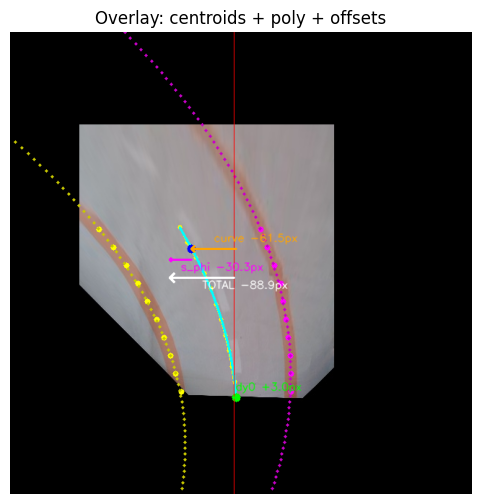

Saved overlay to: outputs/final_overlay_with_offsets.png
===== LATERAL DEVIATION CALCULATION =====

Quantity                          Pixels         Meters
-------------------------------------------------------
Curvature radius (R)              641.44          1.210
Front offset (dy0)                  3.00          0.006
Curve shift                       -61.54         -0.116
Steering shift (s_phi)            -30.33         -0.057
TOTAL Deviation                   -88.87         -0.168



In [104]:
import numpy as np
import math
import cv2
import os
import matplotlib.pyplot as plt

# ---------------- USER PARAMETERS ----------------
X0 = 310.0           # vehicle reference center x in pixels
LOOK_Y_PX = 300.0    # lookahead y pixel
L_px = 250.0         # lookahead distance in pixels
WHEELBASE_PX = 0.17 / 0.33 * 175.0  # approximate wheelbase in pixels
PHI_DEG = 5.0

# Overlay image (dummy example; replace with actual BEV overlay)
if 'overlay' not in globals():
    overlay = np.zeros((600, 640, 3), dtype=np.uint8)

# Example centerline points (replace with actual centroids from pipeline)
if 'center_poly' not in globals():
    center_poly = [[320, 500],[325, 400],[330, 300]]

# ---------------- POLYNOMIAL FIT ----------------
centers_arr = np.asarray(center_poly, dtype=float)
ys = centers_arr[:, 1]
xs = centers_arr[:, 0]

deg_fit = 2 if ys.size >= 3 else max(1, ys.size - 1)
coeffs_px = np.polyfit(ys, xs, deg_fit)
p_px = np.poly1d(coeffs_px)

# ---------------- COMPUTE LATERAL POINTS ----------------
y_look_px = float(LOOK_Y_PX)
x_look_px = float(p_px(y_look_px))

idx_front = np.argmax(ys)
x_front_px = xs[idx_front]
y_front_px = ys[idx_front]

dy0_px = x_front_px - X0
curve_px = x_look_px - x_front_px

phi_rad = math.radians(PHI_DEG)
s_phi_px = - (L_px**2 * math.tan(phi_rad) / (2 * WHEELBASE_PX)) if abs(phi_rad) > 1e-12 else 0.0

Delta_total_px = dy0_px + curve_px + s_phi_px

# ---------------- CURVATURE CALCULATION ----------------
xprime_px = p_px.deriv(1)(y_look_px)
x2prime_px = p_px.deriv(2)(y_look_px)
kappa_px = abs(x2prime_px) / (1 + xprime_px**2)**1.5
R_px = 1.0 / kappa_px if kappa_px > 1e-12 else float('inf')

# ---------------- PIXEL TO METER CONVERSION ----------------
XM_PER_PX = 0.33 / 175.0
R_m = R_px * XM_PER_PX
dy0_m = dy0_px * XM_PER_PX
curve_m = curve_px * XM_PER_PX
s_phi_m = s_phi_px * XM_PER_PX
Delta_total_m = Delta_total_px * XM_PER_PX

# ---------------- OVERLAY VISUALIZATION ----------------
vis = overlay.copy()

# Draw centerline points
for x, y in zip(xs, ys):
    cv2.circle(vis, (int(round(x)), int(round(y))), 3, (0,255,255), -1)  # yellow

# Draw fitted curve
y_plot = np.linspace(min(ys), max(ys), 400)
x_plot = p_px(y_plot)
for i in range(len(x_plot)-1):
    cv2.line(vis, (int(round(x_plot[i])), int(round(y_plot[i]))),
             (int(round(x_plot[i+1])), int(round(y_plot[i+1]))), (255,255,0), 2)  # cyan

# Draw front and lookahead points
cv2.circle(vis, (int(round(x_front_px)), int(round(y_front_px))), 6, (0,255,0), -1)  # green
cv2.circle(vis, (int(round(x_look_px)), int(round(y_look_px))), 6, (255,0,0), -1)    # blue

# Vehicle reference line
cv2.line(vis, (int(round(X0)), 0), (int(round(X0)), vis.shape[0]-1), (0,0,255), 1)  # red

# Draw arrows for deviations
shifted_look_px = x_look_px + s_phi_px

cv2.arrowedLine(vis, (int(round(X0)), int(round(y_front_px))),
                (int(round(x_front_px)), int(round(y_front_px))), (0,255,0), 2)
cv2.arrowedLine(vis, (int(round(x_front_px)), int(round(y_look_px))),
                (int(round(x_look_px)), int(round(y_look_px))), (0,165,255), 2)
cv2.arrowedLine(vis, (int(round(x_look_px)), int(round(y_look_px+15))),
                (int(round(shifted_look_px)), int(round(y_look_px+15))), (255,0,255), 2)
final_px = X0 + Delta_total_px
cv2.arrowedLine(vis, (int(round(X0)), int(round(y_look_px+40))),
                (int(round(final_px)), int(round(y_look_px+40))), (255,255,255), 2)

# Optional text labels
cv2.putText(vis, f"dy0 {dy0_px:+.1f}px",
            (int(round((X0+x_front_px)/2)), int(round(y_front_px)-10)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)
cv2.putText(vis, f"curve {curve_px:+.1f}px",
            (int(round((x_front_px+x_look_px)/2)), int(round(y_look_px)-10)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,165,255), 1, cv2.LINE_AA)
cv2.putText(vis, f"s_phi {s_phi_px:+.1f}px",
            (int(round((x_look_px+shifted_look_px)/2)), int(round(y_look_px+30))),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,255), 1, cv2.LINE_AA)
cv2.putText(vis, f"TOTAL {Delta_total_px:+.1f}px",
            (int(round((X0+final_px)/2)), int(round(y_look_px+55))),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

# ---------------- SHOW OVERLAY ----------------
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title('Overlay: centroids + poly + offsets')
plt.axis('off')
plt.show()

# ---------------- SAVE OVERLAY ----------------
out_dir = 'outputs'
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'final_overlay_with_offsets.png')
cv2.imwrite(out_path, vis[:, :, ::-1])  # BGR -> RGB
print("Saved overlay to:", out_path)

# ---------------- PRINT LATERAL DEVIATION ----------------
print("===== LATERAL DEVIATION CALCULATION =====\n")
print(f"{'Quantity':<25}{'Pixels':>15}{'Meters':>15}")
print("-"*55)
print(f"{'Curvature radius (R)':<25}{R_px:>15.2f}{R_m:>15.3f}")
print(f"{'Front offset (dy0)':<25}{dy0_px:>15.2f}{dy0_m:>15.3f}")
print(f"{'Curve shift':<25}{curve_px:>15.2f}{curve_m:>15.3f}")
print(f"{'Steering shift (s_phi)':<25}{s_phi_px:>15.2f}{s_phi_m:>15.3f}")
print(f"{'TOTAL Deviation':<25}{Delta_total_px:>15.2f}{Delta_total_m:>15.3f}")
print("===============================================\n")


### 10. Lane-Centering Control (Cascade + Feedforward)

We use a **cascade + feedforward lane-centering controller** that considers:

* Current lateral deviation and lookahead deviation
* Lane curvature (`R`)
* Current speed (`v_cur`) and steering angle (`delta_cur`)

The **total deviation** combines: current offset, curve shift, and steering-induced shift. The **desired steering angle** uses:

* **Feedback** from deviation and yaw angle errors
* **Feedforward** from lane curvature (`v/R`)

**Tunable parameters**: controller gains (`K1, K2, K3`), lookahead distance, and scaling factors for speed and steering (`k_v`, `k_delta`).

Below are reference **block diagram** and **formulas**:

<table>
<tr>
<td><img src="./data/3.png" width="500"></td>
<td><img src="./data/4.png" width="500"></td>
</tr>
</table>

At the end of this computation, we obtain the **desired vehicle control parameters** (speed, steering angle, steering rate) ready to **publish to the vehicle actuators** for lane keeping.

In [105]:
import math

# ---------------- PARAMETERS (single place) ----------------
# Vehicle / state
l_veh = 0.17            # wheelbase [m]
psi_cur = 0.0           # current yaw angle [rad]
psi_dot_cur = 0.0       # current yaw rate [rad/s]

# Controller gains (tunable)
K1 = 0.8   # lateral deviation -> yaw angle
K2 = 0.5   # yaw angle -> yaw rate (controller)
K3 = 1.0   # yaw rate -> steering rate (controller)

# Feedforward / tuning
k_v = 0.5        # speed factor (m/s per sqrt(m) of radius)
k_delta = 1.2    # steering scaling factor

# Driver / actuation params
driver_code = 99
steering_angle_velocity = 1.0  # nominal steering angular velocity [rad/s]

# Desired lateral deviation (target centerline)
dy_des = 0.0
dy_cur = Delta_total_m  # from lane deviation calculation above (m)

# Safety / fallbacks for radius
# R_m should be computed previously; protect against non-positive or extremely small values
R_m_safe = R_m if (R_m is not None and math.isfinite(R_m) and R_m > 0.001) else float('inf')

# ---------------- ADAPTIVE SPEED (based on curvature) ----------------
# Reduce speed for sharper curves (smaller R); fallback default speed 5.0 m/s
if R_m_safe == float('inf'):
    v_cur = 5.0
else:
    v_cur = k_v * math.sqrt(R_m_safe)
    # optional clamp to reasonable bounds
    v_cur = max(0.5, min(v_cur, 8.0))  # keep speed between 0.5 and 8 m/s

# ---------------- DESIRED YAW / YAW RATE ----------------
# Desired yaw angle from lateral deviation (proportional law)
psi_des = K1 * (dy_des - dy_cur)  # rad

# Yaw rate controller (feedback)
psi_dot_des_controller = K2 * (psi_des - psi_cur)

# Pilot/feedforward yaw rate from curvature
psi_dot_des_pilot = 0.0 if R_m_safe == float('inf') else (v_cur / R_m_safe)

# Total desired yaw rate
psi_dot_des = psi_dot_des_controller + psi_dot_des_pilot

# ---------------- STEERING (controller + feedforward) ----------------
# Steering rate demanded by controller
delta_controller = K3 * (psi_dot_des - psi_dot_cur)

# Feedforward desired steering angle from yaw rate (approximate bicycle model)
# protect against division by zero in case v_cur is extremely small
if v_cur <= 1e-3:
    delta_des = 0.0
else:
    delta_des = psi_dot_des * (l_veh / v_cur)

# Combine and scale steering
delta_total = k_delta * (delta_des + delta_controller)

# Optionally convert to degrees for easier inspection
delta_total_deg = math.degrees(delta_total)

# ---------------- PRINT SUMMARY ----------------
print("===== ADAPTIVE VEHICLE CONTROL SUMMARY =====\n")
print(f"Driver code: {driver_code}")
print(f"Steering angle velocity (nominal): {steering_angle_velocity:.3f} rad/s")

print("\n-- Curvature / speed --")
if R_m_safe == float('inf'):
    print("R_m: inf (straight / undefined). Using default speed.")
else:
    print(f"R_m: {R_m_safe:.3f} m")
print(f"Adaptive speed v_cur: {v_cur:.3f} m/s")

print("\n-- Lateral / yaw references --")
print(f"Current lateral deviation dy_cur: {dy_cur:+.3f} m (target {dy_des:.3f} m)")
print(f"Desired yaw angle psi_des: {psi_des:.4f} rad")

print("\n-- Yaw rate contributions --")
print(f"Controller yaw rate (feedback): {psi_dot_des_controller:+.4f} rad/s")
print(f"Pilot yaw rate (feedforward):   {psi_dot_des_pilot:+.4f} rad/s")
print(f"Total desired yaw rate:         {psi_dot_des:+.4f} rad/s")

print("\n-- Steering outputs --")
print(f"Controller steering term: {delta_controller:+.4f} rad")
print(f"Feedforward steering term: {delta_des:+.4f} rad")
print(f"Total steering (scaled) : {delta_total:+.4f} rad  ({delta_total_deg:+.2f} deg)")
print("==============================================\n")


===== ADAPTIVE VEHICLE CONTROL SUMMARY =====

Driver code: 99
Steering angle velocity (nominal): 1.000 rad/s

-- Curvature / speed --
R_m: 1.210 m
Adaptive speed v_cur: 0.550 m/s

-- Lateral / yaw references --
Current lateral deviation dy_cur: -0.168 m (target 0.000 m)
Desired yaw angle psi_des: 0.1341 rad

-- Yaw rate contributions --
Controller yaw rate (feedback): +0.0670 rad/s
Pilot yaw rate (feedforward):   +0.4546 rad/s
Total desired yaw rate:         +0.5217 rad/s

-- Steering outputs --
Controller steering term: +0.5217 rad
Feedforward steering term: +0.1613 rad
Total steering (scaled) : +0.8195 rad  (+46.95 deg)



## II ROS implementation

The existing software stack already provides reliable **locomotion**, **localization**, **perception**, and a calibrated **Inverse Perspective Mapping (IPM)** / BEV pipeline.
Our task is to develop a **robust image-processing and control module** that consumes the stack’s BEV and perception outputs and produces safe, real-time drive commands so the robot:

* stays centered in its lane (or follows the computed centerline), and
* behaves like a lane-keeping assistance system that is resilient to bends, curves and real-world sensor noise.

Concretely, we will deliver two tightly integrated subsystems:

1. **Robust image processing (BEV)** — extract lane polylines, curvature, lateral offset, and detection confidence from the IPM/BEV images; reject spurious detections and smooth noisy estimates.
2. **Model-aware control** — an Ackermann-aware controller that fuses predicted look-ahead deviation (from the vehicle motion model) with feedback (cascade + feedforward) and a graded look-ahead box to produce smooth, rate-limited steering commands and safe fallbacks.

## Robustness & fault handling

* **Confidence checks**: only accept lane model outputs above a confidence threshold; otherwise trigger fallback.
* **Temporal filtering**: exponential smoothing on curvature and offset to remove spikes.
* **Spike and jump rejection**: detect and ignore large instantaneous jumps (clamp + hold previous safe value).
* **Rate limiting**: limit steering command rate to avoid actuator saturation and oscillations.
* **Fallbacks**:

  * both lanes → normal combined control, prefer model-based output if confidence high.
  * single-side → use geometry + motion model + graded search turn.
  * none → slow search/stop behavior and rely on KMeans baseline as a last resort.
  * spurious detections → reject using spatial and temporal consistency checks.
* **Look-ahead box**: spatially smooths corrections (mild → medium → sharp) to avoid over-reacting to noisy instantaneous detections.

## Run & integration (short)

1. Add `Lane_detection_v3` to ROS workspace `src/`.
2. Build (`catkin_make` or `colcon build`) and source workspace.
3. Tune IPM and vehicle parameters in `params/` (homography, wheelbase).
4. Launch stack: `roslaunch lane_detection_v3 lane_detection.launch` (or use `kmeans_baseline.launch` for fallback testing).
5. Visualize `/camera/bev` and `/lane/diagnostics/*` in `rviz` during tests; record bag files for repeatable tuning.

---

### Software architecture:

![Image Processing Pipeline: From BEV Input to Vehicle Actuation](./data/modified.png)

1. KMeans baseline
2. Model-based BEV lane-keeping

# KMeans baseline (package: `realsense_image_tools`)

* New ROS package: `Lane_detection_v3` (codebase currently in package `X`).
* First, a lightweight baseline using **KMeans** on the bird’s-eye / IPM image to cluster lane pixels into two blobs (left / right).
* From those two blobs we compute center points and a centerline — the robot follows the center points.

**Simple error-handling logic**

* If **only left lane** detected → command a gentle/defined right turn to recover.
* If **only right lane** detected → command a gentle/defined left turn to search for the missing lane.
* If **both lanes** detected → follow computed centerline.
* If **none / ambiguous** → fall back to safe behavior (stop or low-speed search mode).

**Quick run (developer steps — generic)**

1. Put `Lane_detection_v3` into your workspace `src/`.
2. Build: `catkin_make` / `colcon build` (depending on ROS distro).
3. Source workspace: `source devel/setup.bash` (or `install/setup.bash`).
4. Launch node/launchfile: `roslaunch lane_detection_v3 lane_detector.launch` (or `rosrun lane_detection_v3 node_name`).
   (Adjust topic names and parameters inside the package as required.)

---

# KMeans Baseline

## 1. Build & source
From  workspace root (e.g. `~/catkin_ws`):
```bash
catkin build -j 2 -DCMAKE_BUILD_TYPE=Release
source devel/setup.bash
````

## 2. Bring up hardware + vision

```bash
roslaunch ika_racer bring_up.launch
roslaunch realsense_image_tools visioncontollnodelet.launch # for this nodelet launches IPM along with k means based lane detection
```


## 5. Params (example `vision_drive_params.yaml`)

Edit `k_steer` and other gains here:

```yaml
vision_controller:
  drive_speed: 1.00
  drive_acceleration: 0.5
  steering_angle_velocity: 3.0
  k_steer: 0.008
  slight_left_steering_angle: 1.0
  slight_right_steering_angle: -1.0
  starter_speed: 1.0
  starter_duration: 0.3  # seconds
```

## 6. topics

```bash
# topics
rostopic list | grep -E "camera|bev|lane|cmd_drive"

# inspect drive commands
rostopic echo /ika_racer/locomotion/drive_command

# record for offline tuning
rosbag record /camera/bev /lane/kmeans/centers /ika_racer/locomotion/drive_command /odom -O run_kmeans.bag
```

![fianl_display](data/0014.jpg)


# Model-aware Control

**Purpose:** Launch the Ackermann-aware controller which fuses look-ahead prediction (motion model) + cascade feedback + feedforward terms and uses a graded look-ahead box for robust steering.

> **Assumptions / notes**
> - Package: `lane_detection_v3`  
> - Hardware bring-up is handled by `ika_racer` bring-up.  
> - The controller is started via `lane_follower.launch` inside `lane_detection_v3`
> - IPM / BEV nodelet runs as part of the launch and provides the bird’s-eye view input.

---

## 1) Build & source (if not already done)
From workspace root (e.g. `~/catkin_ws`):
```bash
catkin build -j 2 -DCMAKE_BUILD_TYPE=Release
source devel/setup.bash
````

## 2) Bring up hardware

```bash
roslaunch ika_racer bring_up.launch
```

## 3) Launch model-aware lane follower

```bash
# start the lane follower (this launch starts the IPM/nodelet + controller)
roslaunch lane_detection_v3 lane_follower.launch
```

*(If your launch file has a different name, e.g. `lane_follwer.lauch`, replace with the correct filename.)*

## 4) Load / edit tuning params

Tunable parameters live here in the package (edit before or load at runtime):

```
lane_detection_v3/config/lane.yaml
```

Example keys you will find / tune:

```yaml
# config/lane.yaml

# Image target size (pixels)
target_width: 640
target_height: 640

# HSV thresholds for yellow lane detection (kept - algorithm unchanged)
hsv_yellow_lower: [2, 50, 80]
hsv_yellow_upper: [25, 200, 220]

# Polynomial fitting parameters
poly_degree: 2
fit_margin: 50
min_poly_pixels: 50

# Sliding window parameters
win_count: 12
win_half_width: 35
win_min_pixels: 10
win_start_y: 520
win_end_y: 256

# Lookahead box
lookahead_xmin: 305
lookahead_xmax: 335
lookahead_ymin: 200
lookahead_ymax: 480

# Strips and lane prior
strip_min_points: 10
min_lane_distance: 180

# Steering discrete thetas
theta_r1: 0.5
theta_r2: 1.0
theta_r3: 1.5
theta_l1: -0.5
theta_l2: -1.0
theta_l3: -1.5

# Vehicle / driver parameters (fixed)
driver_code: 99
base_acceleration: 0.3
steering_angle_velocity: 1.0

# Debug
debug: true

# Speed parameters (requested)
speed_step: 0.02
min_speed: 0.35
max_speed: 0.45

# NEW parameter — use speed sensor? (true = use sensor, false = ignore and send max_speed)
speed_senser: false

# Smoothing
steering_smooth_factor: 0.4
no_lane_speed: 0.38

# ROI polygon (normalized coords)
roi_poly_norm:
  - [0.15, 0.80]
  - [0.75, 0.80]
  - [0.75, 0.40]
  - [0.15, 0.40]

# Histogram / anchor tuning
hist_peak_min_value: 30
bottom_roi_fraction: 0.20

# Sobel & search tuning
sobel_threshold: 20.0
min_allowed_jump: 20
min_win_half: 8
curvature_center_gain: 50.0

# Center polyline params
center_point_count: 12
center_min_side_margin: 75
center_point_alpha: 0.5
curvature_smoothing: 0.3
center_alpha: 0.20

# Optional polynomial fitting params
poly_smoothing_alpha: 0.7
ransac_iterations: 50
ransac_threshold: 10.0

```

To load at runtime:

```bash
rosparam load $(rospack find lane_detection_v3)/config/lane.yaml
```

(or `rosparam load /full/path/to/lane.yaml`)

## 5) Topics to watch

* Final visual overlay (BEV + lanes + look-ahead box):

```bash
# image topic showing final overlay
rostopic echo /final_overlay   # use rqt_image_view or RViz Image display for visualization
```

* Drive command (controller output sent to locomotion):

```bash
rostopic echo /ika_racer/locomotion/drive_command
# or inspect fields for speed / steering_angle / steering_angle_velocity
```
![demo](./data/final2.gif)


# Conclusion

The project highlights that hardware choices and software architecture are tightly coupled: algorithmic choices must respect compute and sensor constraints for practical deployment. There is no single universal solution; instead, robust system design is about selecting a set of complementary tools (classical vision for speed, selective learned components for robustness) and engineering dependable calibration, logging and testing processes. As automotive compute resources rise, more sophisticated perception models will become feasible on embedded platforms, but carefully engineered lightweight approaches remain relevant for education, rapid prototyping and constrained deployments. The lessons learned from the scaled platform can guide both teaching and research and form a practical bridge to full-scale autonomous vehicle development.

# Bibliography

[1] https://www.google.com/imgres?q=waveshare%20jetracer%20nano&imgurl=https%3A%2F%2Fm.media-amazon.com%2Fimages%2FI%2F61RwbtVUmVL._UF1000%2C1000_QL80_.jpg&imgrefurl=https%3A%2F%2Fwww.amazon.de%2F-%2Fen%2FWaveshare-JetRacer-Accessory-Following-Autonomous%2Fdp%2FB0BK9FJVML&docid=BzGy_hUPOcOYAM&tbnid=XqUqbxBi-dWcfM&vet=12ahUKEwiitq-T4dWPAxVrQvEDHenNM54QM3oECB0QAA..i&w=1000&h=750&hcb=2&itg=1&ved=2ahUKEwiitq-T4dWPAxVrQvEDHenNM54QM3oECB0QAA

[2] https://en.wikipedia.org/wiki/Sobel_operator

[3] https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html

[4] https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de

[5] https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html

[6] https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga8618180a5948286384e3b7ca02f6feeb

[7] https://en.wikipedia.org/wiki/K-means_clustering